# **Location of the stress factor in potential evapo-transpiration models**

# Part I - Methodology 

## <u> Motivation </u> 

### Theoretical background

In the literature, this scaling of the potential evapo-transpiration is commonly found with simpler radiation-temperature models such as the Priestley and Taylor model instead of the Penman-Monteith one. Recall the expression of the Priestley and Taylor model: 

\begin{equation}\label{eq_PT}
    \lambda E_{p,PT} = \alpha \frac{\Delta}{\Delta + \gamma}(Rn - G)
\end{equation}

The Priestley and Taylor is not physicaly based as can be the Penman-Monteith model. Then we aim at investigating the differences obtained when using such a model. 

This notebook compares different newly implemented models : 
* Priestley and Taylor model with a stress factor : 
\begin{align}
    E_{a, PT}  = f_{PAR}.S(\theta).E_{p,PT}(\textbf{X})
\end{align}

* Modified varying surface conductance Penman-Monteith model :
\begin{align}
    E_{a, var, PM}  = f_{PAR}.E_{p,PM mod}(\textbf{X}, S(\theta))
\end{align}

* Modified constant surface conductance Penman-Monteith model :
\begin{align}
    E_{a, cst, PM}  = f_{PAR}.S(\theta).E_{p,PM mod}(\textbf{X})
\end{align}

The modified version of the Penman-Monteith equation takes into account the double sided exchange of sensible heat. This model was developped at the leaf scale but is tested here at the canopy scale in the framework of the big leaf model (*Schymanski and Or, 2017*). The analytical expression of the modified expression is henceforth: 
\begin{equation}
E = \frac{1}{\lambda}\frac{\Delta (R_n - G) + c_p \rho_a g_a a_{sh} VPD }{\Delta + \gamma \left( 1+ \frac{g_a}{g_s} \right) \frac{a_{sh}}{a_s}}
\end{equation}

### Modelling experiements

Different experiments are carried out to compare the different models and assess their behavior: 
1. All models are calibrated for a single year and their ability to reproduce an observed time serie is assessed
2. Their prediction capability is evaluated by randomly taking one or several years of data from the Howard Springs dataset, calibrating the model for this specific year and predicting the evapo-transpiration time serie for the other years. 
3. The same procedure is repeated across different sites in Australia

# Part II - Functions set up

## Importing relevant packages

In [1]:
# data manipulation and plotting
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib._layoutgrid import plot_children
from collections import OrderedDict
from IPython.display import display
import os # to look into the other folders of the project
import importlib.util # to open the .py files written somewhere else
#sns.set_theme(style="whitegrid")

# Sympy and sympbolic mathematics
from sympy import (asin, cos, diff, Eq, exp, init_printing, log, pi, sin, 
                   solve, sqrt, Symbol, symbols, tan, Abs)
from sympy.physics.units import convert_to
init_printing() 
from sympy.printing import StrPrinter
from sympy import Piecewise
StrPrinter._print_Quantity = lambda self, expr: str(expr.abbrev)    # displays short units (m instead of meter)
from sympy.printing.aesaracode import aesara_function
from sympy.physics.units import *    # Import all units and dimensions from sympy
from sympy.physics.units.systems.si import dimsys_SI, SI

# for ESSM, environmental science for symbolic math, see https://github.com/environmentalscience/essm
from essm.variables._core import BaseVariable, Variable
from essm.equations import Equation
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import (extract_variables, generate_metadata_table, markdown, 
                                  replace_defaults, replace_variables, subs_eq)
from essm.variables.units import (SI_BASE_DIMENSIONS, SI_EXTENDED_DIMENSIONS, SI_EXTENDED_UNITS,
                                  derive_unit, derive_baseunit, derive_base_dimension)

# For netCDF
import netCDF4
import numpy as np
import xarray as xr
import warnings
from netCDF4 import Dataset

# For regressions
from sklearn.linear_model import LinearRegression

# Deactivate unncessary warning messages related to a bug in Numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

# for calibration
from scipy import optimize

from random import random

WARNING (aesara.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Path of the different files (pre-defined python functions, sympy equations, sympy variables)

In [2]:
path_variable = '../../theory/pyFile_storage/theory_variable.py'
path_equation = '../../theory/pyFile_storage/theory_equation.py' 
path_analysis_functions = '../../theory/pyFile_storage/analysis_functions.py'
path_data = '../../../data/eddycovdata/'
dates_fPAR = '../../../data/fpar_howard_spring/dates_v5'

tex_file_whole = "latex_files/whole_year.tex"
tex_file_dry = "latex_files/dry_season.tex"
tex_file_wet = "latex_files/wet_season.tex"

timeSerie_oneSite_oneYear = 'timeSerie_oneSite_oneYear.png'
inverseModelling = "inverseModelling.png"
Influence_atmo_E_dry = "Influence_atmo_E_dry.png"
Influence_atmo_E_wet = "Influence_atmo_E_wet.png"
Influence_atmo_rel_dry = "Influence_atmo_rel_dry.png"
Influence_atmo_rel_wet = "Influence_atmo_rel_wet.png"
sensitivity_parameters = "sensitivity_parameters.png"
statistical_assessment = "statistical_assessment.png"
different_sites = "different_sites.png"

## Importing the sympy variables and equations defined in the theory.ipynb notebook

In [3]:
for code in [path_variable,path_equation]:
    name_code = code[-20:-3]
    spec = importlib.util.spec_from_file_location(name_code, code)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    names = getattr(mod, '__all__', [n for n in dir(mod) if not n.startswith('_')])
    glob = globals()
    for name in names:
        print(name)
        glob[name] = getattr(mod, name)

theta_sat
theta_res
alpha
n
m
S_mvg
theta
h
S
theta_4
theta_3
theta_2
theta_1
L
Mw
Pv
Pvs
R
T
c1
T0
Delta
E
G
H
Rn
LE
gamma
alpha_PT
c_p
w
kappa
z
u_star
VH
d
z_om
z_oh
r_a
g_a
r_s
g_s
c1_e
c2_e
e
T_min
T_max
RH_max
RH_min
e_a
e_s
iv_T
T_kv
P
rho_a
VPD
eq_m_n
eq_MVG_neg_case
eq_MVG
eq_sat_degree
eq_MVG_h
eq_h_FC
eq_theta_4_3
eq_theta_2_1
eq_water_stress_simple
eq_Pvs_T
eq_Delta
eq_PT
eq_PM
eq_PM_VPD
eq_PM_g
eq_PM_inv


## Importing the performance assessment functions defined in the analysis_function.py file

In [4]:
for code in [path_analysis_functions]:
    name_code = code[-20:-3]
    spec = importlib.util.spec_from_file_location(name_code, code)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    names = getattr(mod, '__all__', [n for n in dir(mod) if not n.startswith('_')])
    glob = globals()
    for name in names:
        print(name)
        glob[name] = getattr(mod, name)

AIC
AME
BIC
CD
CP
IoA
KGE
MAE
MARE
ME
MRE
MSRE
MdAPE
NR4MS4E
NRMSE
NS
NSC
PDIFF
PEP
R4MS4E
RAE
RMSE
RVE
np
nt


## Data import, preprocess and shape for the computations

### Get the different files where data are stored

Eddy-covariance data from the OzFlux network are stored in **.nc** files (NetCDF4 files) which is roughly a panda data frame with meta-data (see https://www.unidata.ucar.edu/software/netcdf/ for more details about NetCDF4 file format). fPAR data are stored in **.txt** files

In [5]:
fPAR_files = []
eddy_files = []

for file in os.listdir(path_data):
    if file.endswith(".txt"):
        fPAR_files.append(os.path.join(path_data, file))
    elif file.endswith(".nc"):
        eddy_files.append(os.path.join(path_data, file))
        
fPAR_files.sort()
print(fPAR_files)
eddy_files.sort()
print(eddy_files)

['../../../data/eddycovdata/fpar_adelaide_v5.txt', '../../../data/eddycovdata/fpar_daly_v5.txt', '../../../data/eddycovdata/fpar_dry_v5.txt', '../../../data/eddycovdata/fpar_howard_v5.txt', '../../../data/eddycovdata/fpar_sturt_v5.txt']
['../../../data/eddycovdata/AdelaideRiver_L4.nc', '../../../data/eddycovdata/DalyUncleared_L4.nc', '../../../data/eddycovdata/DryRiver_L4.nc', '../../../data/eddycovdata/HowardSprings_L4.nc', '../../../data/eddycovdata/SturtPlains_L4.nc']


### Define and test a function that process the fPAR data
In the **.txt** files, only one value per month is given for the fPAR. The following function takes one .txt file containing data about the fPAR coefficients, and the related dates, stored in the a seperate file. The fPAR data (date and coefficients) are cleaned (good string formatting), mapped together and averaged to output one value per month (the fPAR measurement period doesn't spans the measurement period of the eddy covariance data)

In [6]:
def fPAR_data_process(fPAR_file,dates_fPAR):
    
    fparv5_dates = np.genfromtxt(dates_fPAR, dtype='str', delimiter=',')
    fparv5_dates = pd.to_datetime(fparv5_dates[:,1], format="%Y%m")
    dates_pd = pd.date_range(fparv5_dates[0], fparv5_dates[-1], freq='MS')

    fparv5_howard = np.loadtxt(fPAR_file,delimiter=',', usecols=3 )
    fparv5_howard[fparv5_howard == -999] = np.nan
    fparv5_howard_pd = pd.Series(fparv5_howard, index = fparv5_dates)
    fparv5_howard_pd = fparv5_howard_pd.resample('MS').max()

    # convert fparv5_howard_pd to dataframe
    fPAR_pd = pd.DataFrame(fparv5_howard_pd)
    fPAR_pd = fPAR_pd.rename(columns={0:"fPAR"})
    fPAR_pd.index = fPAR_pd.index.rename("time")

    # convert fPAR_pd to xarray to aggregate the data
    fPAR_xr = fPAR_pd.to_xarray()
    fPAR_agg = fPAR_xr.fPAR.groupby('time.month').max()

    # convert back to dataframe
    fPAR_pd = fPAR_agg.to_dataframe()
    Month = np.arange(1,13)
    Month_df = pd.DataFrame(Month)
    Month_df.index = fPAR_pd.index
    Month_df = Month_df.rename(columns={0:"Month"})

    fPAR_mon = pd.concat([fPAR_pd,Month_df], axis = 1)
    
    return(fPAR_mon)

In [7]:
fPAR_data_process(fPAR_files[3],dates_fPAR)

fPAR  Month
month             
1      0.78      1
2      0.84      2
3      0.79      3
4      0.84      4
5      0.71      5
6      0.75      6
7      0.60      7
8      0.54      8
9      0.52      9
10     0.67     10
11     0.73     11
12     0.78     12

### fPARSet function
Map the fPAR time serie to the given eddy-covariance data. Takes two dataframes as input (one containing the fPAR data, the other containing the eddy-covariance data) and returns a data frame where the fPAR monthly values have been scaled to the time scale of the eddy covariance data

In [8]:
def fPARSet(df_add, fPAR_pd):
    
    # construct the time serie of the fPAR coefficients
    dummy_len = df_add["Fe"].size
    fPAR_val = np.zeros((dummy_len,))
    
    dummy_pd = df_add
    dummy_pd.reset_index(inplace=True)
    dummy_pd.index=dummy_pd.time
    
    month_pd = dummy_pd['time'].dt.month
    
    for i in range(dummy_len):
        current_month = month_pd.iloc[i]
        line_fPAR = fPAR_pd[fPAR_pd['Month'] == current_month]
        fPAR_val[i] = line_fPAR['fPAR']
    
    # transform fPAR_val into dataframe to concatenate to df:
    fPAR = pd.DataFrame(fPAR_val, index = df_add.index)
    df_add = pd.concat([df_add,fPAR], axis = 1)
    df_add = df_add.rename(columns = {0:"fPAR"})
    
    return(df_add)

### DataChose function

Function taking the raw netcdf4 data file from the eddy covariance measurement and shape it such that it can be used for the computations. Only relevant variables are kept (latent heat flux, net radiation, ground heat flux, soil water content, wind speed, air temperature, VPD, bed shear stress). The desired data period is selected and is reshaped at the desired time scale (daily by default). Uses the fPARSet function defined above

List of variable abbreviation : 
* `Rn` : Net radiation flux
* `G` : Ground heat flux 
* `Sws` : soil moisture
* `Ta` : Air temperature
* `RH` : Relative humidity
* `W` : Wind speed
* `E` : measured evaporation
* `VPD` : Vapour pressure deficit

In [9]:
def DataChose(ds_ref, period_sel, fPAR_given, Freq = "D", sel_period_flag = True):
    """Take subset of dataset if Flag == True, entire dataset else
    
    ds_ref: xarray object to be considered as the ref for selecting attributes
    agg_flag: aggregate the data at daily time scale if true
    Flag: select specific period if true (by default)
    period: time period to be selected
    ----------
    Method : 
    - transform the xarray in panda dataframe for faster iteration
    - keep only the necessary columns : Fe, Fn, Fg, Ws, Sws, Ta, ustar, RH
    - transform / create new variables : Temperature in °C, T_min/T_max, RH_min/RH_max
    - create the Data vector (numpy arrays)
    - create back a xarray 
    - return an xarray
    ----------
    
    Returns an xarray and a Data vector
    """
    
    if sel_period_flag:
        df = ds_ref.sel(time = period_sel) 
        # nameXarray_output = period + "_" + nameXarray_output
    else : 
        df = ds_ref
        
    # keep only the columns of interest
    df = df[["Fe","Fn","Fg","Ws","Sws","Ta","ustar","RH", "VPD","ps"]]
    
    # convert to dataframe
    df = df.to_dataframe()
    
    # aggregate following the rule stated in freq
    pd_Tmin = df.Ta.groupby([pd.Grouper(level = "latitude"), pd.Grouper(level = "longitude"), pd.Grouper(level = "time", freq = Freq)]).min()
               
    pd_Tmax = df.Ta.groupby([pd.Grouper(level = "latitude"), pd.Grouper(level = "longitude"), pd.Grouper(level = "time", freq = Freq)]).max()
    
    pd_RHmin = df.RH.groupby([pd.Grouper(level = "latitude"), pd.Grouper(level = "longitude"), pd.Grouper(level = "time", freq = Freq)]).min()
    
    pd_RHmax = df.RH.groupby([pd.Grouper(level = "latitude"), pd.Grouper(level = "longitude"), pd.Grouper(level = "time", freq = Freq)]).max()
    
    df = df.groupby([pd.Grouper(level = "latitude"), pd.Grouper(level = "longitude"), pd.Grouper(level = "time", freq = Freq)]).mean()
    df = pd.DataFrame(df)
    
    pd_Tmin = pd.DataFrame(pd_Tmin, index = df.index)
    pd_Tmin = pd_Tmin.rename(columns = {"Ta":"Ta_min"})
    
    pd_Tmax = pd.DataFrame(pd_Tmax, index = df.index)
    pd_Tmax = pd_Tmax.rename(columns = {"Ta":"Ta_max"})
    
    pd_RHmin = pd.DataFrame(pd_RHmin, index = df.index)
    pd_RHmin = pd_RHmin.rename(columns = {"RH":"RH_min"})
    
    pd_RHmax = pd.DataFrame(pd_RHmax, index = df.index)
    pd_RHmax = pd_RHmax.rename(columns = {"RH":"RH_max"})
    
    df = pd.concat([df,pd_Tmin,pd_Tmax,pd_RHmin,pd_RHmax],axis = 1)
    
    # convert data to the good units : 
    df["Fe"] = df["Fe"]/2.45e6 # divide by latent heat of vaporization
    df["Ta"] = df["Ta"]+273 # convert to kelvin
    df["VPD"] = df["VPD"]*1000 # convert from kPa to Pa
    
    # construct the time serie of the fPAR coefficients
    df = fPARSet(df,fPAR_given)
    
    # initialise array for the error
    Error_obs = np.zeros((df.Fe.size,))
    
    for i in range(df.Fe.size):
        size_window_left, size_window_right = min(i,7),min(df.Fe.size - i-1, 7)
        #print(size_window_left, size_window_right)
        sub_set = df.Fe[i-size_window_left : i+size_window_right].to_numpy()
        mean_set = np.mean(sub_set)
        sdt_set = np.std(sub_set)
        error_obs = 2*sdt_set
        Error_obs[i] = error_obs
    
    ErrorObs = pd.DataFrame(Error_obs, index = df.index)
    
    df = pd.concat([df,ErrorObs], axis = 1)
    df = df.rename(columns = {0:"error"})

        
    return(df)

## Compile the different functions defined in the symbolic domain
All functions defined with sympy and ESSM are defined in the symbolic domain. In order to be efficiently evaluated, they need to be vectorized to allow computations with numpu arrays. We use the *aesara* printing compiler from the sympy package. Note that this printer replace the older one (*theano*) which is deprecated. A comparison of the performances between the two packages can be found in the aesara repository.

### Water stress functions

In [10]:
def rising_slope_compiled():
    """Compile the slope of the function between theta 4 and theta 3"""
    
    rising_slope = aesara_function([theta,theta_3, theta_4], [eq_theta_4_3.rhs], dims = {theta:1, theta_3:1, theta_4:1})
    
    return(rising_slope)

def desc_slope_compiled():
    """Compile the slope of the function between theta 2 and theta 1"""
    
    desc_slope = aesara_function([theta,theta_1, theta_2], [eq_theta_2_1.rhs], dims = {theta:1, theta_1:1, theta_2:1})
    
    return(desc_slope)

### Soil water potential

In [11]:
def relative_saturation_compiled(ThetaRes, ThetaSat):
    """Compile the relative saturation function of a soil"""
    Dict_value = {theta_res : ThetaRes, theta_sat : ThetaSat}
    
    S_mvg_func = aesara_function([theta], [eq_sat_degree.rhs.subs(Dict_value)], dims = {theta:1})
    
    return(S_mvg_func)

In [12]:
def Psi_compiled(alphaVal, nVal):
    """Compile the soil water retention function as function of theta"""
    mVal = 1-1/nVal
    
    Dict_value = {alpha : alphaVal, n : nVal, m : mVal}
    
    Psi_function = aesara_function([S_mvg], [eq_MVG_h.rhs.subs(Dict_value)], dims = {S_mvg:1})
    
    return(Psi_function)

### Penman-Monteith

In [13]:
def Delta_compiled():
    """Compile the Delta function"""
    
    # creating the dictionnary with all default values from the above defined constants
    var_dict = Variable.__defaults__.copy()
    
    # computing delta values out of temperature values (slope of the water pressure curve)
    Delta_func = aesara_function([T],[eq_Delta.rhs.subs(var_dict)], dims = {T:1})
    
    return(Delta_func)

In [14]:
def VH_func_compiled(z_val):
    """Compute the vegetation height function
    --------------------------------------------------------
    z : height of the measurements (m)
    kappa : Von Karman constant
    
    w : wind velocity (m/s)
    u_star : shear stress velocity (m/s)
    --------------------------------------------------------
    
    Return a function with w and u_star as degrees of freedom
    """
    # get the constant values
    Dict_value = {z:z_val,kappa:kappa.definition.default}
    
    # compile the function
    VH_func = aesara_function([w,u_star],[VH.definition.expr.subs(Dict_value)], dims = {w:1, u_star:1})
    
    return(VH_func)

In [15]:
def d_func_compiled():
    """Compile the zero plane displacement height function
    --------------------------------------------------------
    VH : Vegetation height
    --------------------------------------------------------
    
    return a function with VH as degree of freedom
    """
    
    # compile the function 
    d_func = aesara_function([VH], [d.definition.expr], dims = {VH:1})
    
    return(d_func)

In [16]:
def zom_func_compiled():
    """Compile the characteristic momentum height exchange
    --------------------------------------------------------
    VH : Vegetation height
    --------------------------------------------------------
    
    return a function with VH as degree of freedom
    """
    
    # compile the function 
    zom_func = aesara_function([VH], [z_om.definition.expr], dims = {VH:1})
    
    return(zom_func)

In [17]:
def zoh_func_compiled():
    """Compile the characteristic heat height exchange
    --------------------------------------------------------
    VH : Vegetation height
    --------------------------------------------------------
    
    return a function with VH as degree of freedom
    """
    
    # compile the function 
    zoh_func = aesara_function([z_om], [z_oh.definition.expr], dims = {z_om:1})
    
    return(zoh_func)

In [18]:
def ra_func_compiled(z_val):
    """Substitutes the different terms of the r_a expression
    --------------------------------------------------------
    z : height of the measurement (m)
    
    d : zero plane displacement height (m)
    zoh_val : characteristic height of the heat transfert
    zom_val : characteristic height of the momentum transfert
    --------------------------------------------------------
    
    returns the compiled expression of r_a evaluable according to the wind speed
    """
    # evaluate the values in the expression
    Dict_value = {z:z_val,kappa:kappa.definition.default}
    
    # compile the function
    ra_func = aesara_function([z_om,z_oh,d,w], [r_a.definition.expr.subs(Dict_value)], dims = {z_om:1,z_oh:1,d:1,w:1})
    
    return(ra_func)

In [19]:
def ea_func_compiled():
    """ Compute the actual water vapour deficit with RH and T (min/max) left as degree of freedom
    --------------------------------------------------------
    c1 : internal variable 
    c2 : internal variable 
    
    T_min : time serie of daily min temperature
    T_max : time serie of daily max temperature 
    RH_min : time serie of daily min relative humidity 
    RH_max : time serie of daily max relative humidity
    --------------------------------------------------------
    
    retunrs the compiled expression of the e_a function with four degrees of freedom 
    """
    
    # get the constants
    Dict_value = {c1_e:c1_e.definition.default, c2_e:c2_e.definition.default}
    
    #compile the function
    ea_func = aesara_function([T_min,T_max,RH_min,RH_max],[e_a.definition.expr.subs(Dict_value)], dims={T_min:1, T_max:1, RH_min:1, RH_max:1})
    
    return(ea_func)

In [20]:
def es_func_compiled():
    """Compute the saturation water vapour deficit with T (min / max) left as degree of freedom 
    --------------------------------------------------------
    c1 : internal variable 
    c2 : internal variable 
    
    T_min : time serie of daily min temperature
    T_max : time serie of daily max temperature 
    --------------------------------------------------------
    
    retunrs the compiled expression of the e_s function with four degrees of freedom 
    """
    
    # get the constants
    Dict_value = {c1_e:c1_e.definition.default, c2_e:c2_e.definition.default}
    
    #compile the function
    ea_func = aesara_function([T_min,T_max],[e_s.definition.expr.subs(Dict_value)], dims={T_min:1, T_max:1})
    
    return(ea_func)    

In [21]:
def PM_compiled():
    """ Compute the compiled version of the PM VPD equation
    --------------------------------------------------------
    c_p : specific heat of the air
    rho_a : mean air density
    gamma : psychrometric constant
    L : Latent heat flux
    
    r_s : Surface resistance -> given (can also be modeled)
    G : ground heat flux -> comes from the data
    Rn : net radiation flux -> comes from the data 
    Delta : slope of the saturation curve -> computed above
    r_a : aerodynamic resistance -> computed above
    --------------------------------------------------------
    
    returns the evaporation flux (in mm/time) with Delta, G, Rn, e_a, e_s, r_a as degrees of freedom
    """
    
    # get the constant values
    Dict_value = {c_p:c_p.definition.default, rho_a:rho_a.definition.default, L:L.definition.default, gamma:gamma.definition.default}
    
    # compile the function
    PM_func = aesara_function([G,Rn,Delta,VPD,g_a, g_s], [eq_PM_g.rhs.subs(Dict_value)], dims = {G:1,Rn:1,Delta:1,VPD:1,g_a:1, g_s:1})
    
    return(PM_func)

In [22]:
def PT_compiled():
    """Compute the Priestley-Taylor equation,
    need 4 input : temperature, net radiations, ground heat flux and alpha PT parameter
    Each must be given as np.array
    Return the compiled function
    """
    
    # creating the dictionnary with all default values from the above defined constants
    var_dict = Variable.__defaults__.copy()
    
    # Computing the values of evaporation using the Priestley-Taylor model
    PT_func = aesara_function([Delta,Rn,G, alpha_PT],[eq_PT.rhs.subs(var_dict)],dims = {Delta:1,Rn:1,G:1, alpha_PT:1})

    return(PT_func)

In [23]:
def rs_PM_inv():
    "Derive the time serie of the surface resistance out of the observed latent heat fluxes --> inverse modelling of the PM equation"
    
    #get the constant values 
    Dict_value = {c_p:c_p.definition.default, rho_a:rho_a.definition.default, L:L.definition.default, gamma:gamma.definition.default}
    
    # compile the function
    Inv_PM = aesara_function([E,G,Rn,Delta,VPD,r_a], [eq_PM_inv.rhs.subs(Dict_value)], dims = {E:1,G:1,Rn:1,Delta:1,VPD:1,r_a:1})
    
    return(Inv_PM)

### Assign the different compiled functions to variables functions (create the functions in python)

In [24]:
# Water_stress properties: 
rising_slope = rising_slope_compiled() # takes theta, theta_3, theta_4 in this order as input
desc_slope = desc_slope_compiled() # takes theta, theta_1, theta_2 in this order as input

# properties : 
delta_func = Delta_compiled() # takes Ta as input
z_val = 23 # change the values of the aerodynamic constants here !!!
VH_func = VH_func_compiled(z_val)
d_func = d_func_compiled()
zom_func = zom_func_compiled()
zoh_func = zoh_func_compiled()
ra_func = ra_func_compiled(z_val)
eSat_func = es_func_compiled()
ea_func = ea_func_compiled()

# models
PM_func = PM_compiled()
PT_func = PT_compiled()
Inv_PM_func = rs_PM_inv()

In [25]:
def stress_factor_func(psi_vec,Psi_3,Psi_4):
    
    Length = psi_vec.size
    
    Stress_func = np.zeros((Length,))
    Psi_3 = np.array([Psi_3])
    Psi_4 = np.array([Psi_4])
    for j in range(Length):
        try:
            Psi_val = psi_vec[j]
        except Exception as error:
            print(psi_vec,error)
        # have to convert float to arrays in order to run the compiled functions
        Psi_val = np.array([Psi_val])
        if (Psi_val < Psi_4):
            Stress_func[j] = 0
        elif (Psi_val >= Psi_4) & (Psi_val < Psi_3):
            Stress_func[j] = float(rising_slope(Psi_val,Psi_3,Psi_4))
        else:
            Stress_func[j] = 1
    return(Stress_func)

## Functions to run the different models
Once the functions has been defined in sympy, compiled with aesara and assign to a useful python function, it is now time to link it with the data to carry out the final computations ! All the following functions take a dataframe as input, and the related parameters ($\theta_3$ and $\theta_4$ for the stress function) and return a numpy array and a dictionnary containing the values of the model run and some miscellaneous information.

### Varying surface resistance model

In [26]:
def PM_run_var(data, Psi_3_val, Psi_4_val, gs_val = 1/70, compute_VPD = False):
    """run varying SR Penman Monteith model but with VPD data instead of Ea and Es
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Psi_3_val: vector of the same size as the vectors in data, full of the value Psi_3
    Psi_4_val: vector of the same size as the vectors in data, full of the value Psi_4
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------
    

    # Stress factor:
    FF_vec = stress_factor_func(Sws_val,Psi_3_val,Psi_4_val)
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)
    Ga_T = 1/Ra_T

    # surface resistance:
    Gs_T = gs_val*FF_vec+0.0001
    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PM_var = fPAR_val*PM_func(Fg_val,Fn_val,D_T,VPD_val,Ga_T, Gs_T) # R_s varying with theta
    
    Dic_var = {"ga":Ga_T, "gs":Gs_T, "D_T":D_T}
    
    return(PM_var)

### Constant surface conductance model

In [27]:
def PM_run_cst(data, Psi_3_val, Psi_4_val, gs_val = 1/70, compute_VPD = False):
    """run constant SR Penman Monteith mode but with VPD data instead of Ea and Es
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    T1_val: vector of the same size as the vectors in data, full of the value T1
    T3_val: vector of the same size as the vectors in data, full of the value T3
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------
    

    # Stress factor:
    FF_vec = stress_factor_func(Sws_val,Psi_3_val,Psi_4_val)
    
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)
    Ga_T = 1/Ra_T

    # surface resistance:
    Gs_C = gs_val*np.ones((Ta_val.size,)) # -> for constant resistance model -> Rs is constant and Ea = S(theta)*E_PM
    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PM_cst = fPAR_val*FF_vec*PM_func(Fg_val,Fn_val,D_T,VPD_val,Ga_T, Gs_C) # R_s constant but stress factor in front of the PM evaluation
    
    Dic_var = {"ga":Ga_T, "gs":Gs_C, "D_T":D_T}
    
    return(PM_cst)

### Benchmark Penman-Monteith model

In [28]:
def PM_run_classic_fPAR(data, gs_val = 1/70, compute_VPD = False):
    """run classic PM model (only Rs as calibration parameter)
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Rs_val: value of the SR
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
            
    # --------------------------
    # derive the two Penman models
    # --------------------------
    
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)
    Ga_T = 1/Ra_T

    # surface resistance:
    Gs_C = gs_val*np.ones((Ta_val.size,)) # -> for constant resistance model -> Rs is constant and Ea = S(theta)*E_PM
    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PM_cst = fPAR_val*PM_func(Fg_val,Fn_val,D_T,VPD_val,Ga_T, Gs_C) # R_s constant but stress factor in front of the PM evaluation
    
    Dic_var = {"ga":Ga_T, "gs":Gs_C, "D_T":D_T}
    
    return(PM_cst)

In [29]:
def PM_run_classic(data, gs_val = 1/70, compute_VPD = False):
    """run classic PM model (only Rs as calibration parameter)
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Rs_val: value of the SR
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
            
    # --------------------------
    # derive the two Penman models
    # --------------------------
    
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)
    Ga_T = 1/Ra_T

    # surface resistance:
    Gs_C = gs_val*np.ones((Ta_val.size,)) # -> for constant resistance model -> Rs is constant and Ea = S(theta)*E_PM
    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PM_cst = PM_func(Fg_val,Fn_val,D_T,VPD_val,Ga_T, Gs_C) # R_s constant but stress factor in front of the PM evaluation
    
    Dic_var = {"ga":Ga_T, "gs":Gs_C, "D_T":D_T}
    
    return(PM_cst)

### Modified version of the PM equation

2 Sided PM evapotranspiration model from *Schymanski and Or, 2017* : 
\begin{equation}
E = \frac{1}{\lambda}\frac{\Delta (R_n - G) + c_p \rho_a g_a a_{sh} VPD }{\Delta + \gamma \left( 1+ \frac{g_a}{g_s} \right) \frac{a_{sh}}{a_s}}
\end{equation}

with $a_{sh}$ and $a_s$ the fraction of projected area exchanging sensible heat flux with the air and fractio of one sided-leaf area covered by stomatas respectively. In the case of amphistomateous leaves, $a_s = 2$ and $a_s = 1$ for hypostomateous leaves. For the Howard Spring site, we consider $a_s = 2$

In [30]:
def PM_run_2var(data, Psi_3_val, Psi_4_val, gs_val = 1/70, compute_VPD = False):
    """run varying SR Penman Monteith model but with VPD data instead of Ea and Es
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Psi_3_val: vector of the same size as the vectors in data, full of the value Psi_3
    Psi_4_val: vector of the same size as the vectors in data, full of the value Psi_4
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------
    

    # Stress factor:
    FF_vec = stress_factor_func(Sws_val,Psi_3_val,Psi_4_val)
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)
    Ga_T = 2/Ra_T # multiply by 2 to account for the 2 sided exchange of latent heat flux

    # surface resistance:
    Gs_T = gs_val*FF_vec+0.0001
    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PM_var = fPAR_val*PM_func(Fg_val,Fn_val,D_T,VPD_val,Ga_T, Gs_T) # R_s varying with theta
    
    Dic_var = {"ga":Ga_T, "gs":Gs_T, "D_T":D_T}
    
    return(PM_var)

In [31]:
def PM_run_2cst(data, Psi_3_val, Psi_4_val, gs_val = 1/70, compute_VPD = False):
    """run constant SR Penman Monteith mode but with VPD data instead of Ea and Es
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    T1_val: vector of the same size as the vectors in data, full of the value T1
    T3_val: vector of the same size as the vectors in data, full of the value T3
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------
    

    # Stress factor:
    FF_vec = stress_factor_func(Sws_val,Psi_3_val,Psi_4_val)
    
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)
    Ga_T = 2/Ra_T # multiply by 2 to account for the 2 sided exchange of latent heat flux

    # surface resistance:
    Gs_C = gs_val*np.ones((Ta_val.size,)) # -> for constant resistance model -> Rs is constant and Ea = S(theta)*E_PM
    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PM_cst = fPAR_val*FF_vec*PM_func(Fg_val,Fn_val,D_T,VPD_val,Ga_T, Gs_C) # R_s constant but stress factor in front of the PM evaluation
    
    Dic_var = {"ga":Ga_T, "gs":Gs_C, "D_T":D_T}
    
    return(PM_cst)

### Priestley and Taylor model

In [32]:
def PT_run(data,Psi_3_val, Psi_4_val, alpha_val = 1.26, compute_VPD = False):
    """run classic PM model (only Rs as calibration parameter)
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Rs_val: value of the SR
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    #Fe_val = data["Fe"].to_numpy()
    #Ws_val = data["Ws"].to_numpy()
    #Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------

    # Stress factor:
    FF_vec = stress_factor_func(Sws_val,Psi_3_val,Psi_4_val)
    
    # surface resistance:
    Alpha_vec = alpha_val*np.ones((Ta_val.size,))

    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PT_mod = fPAR_val*FF_vec*PT_func(D_T,Fn_val,Fg_val,Alpha_vec)
    
    Dic_var = {"D_T":D_T}
    
    return(PT_mod)

In [33]:
def PT_run_potential(data,Psi_3_val, Psi_4_val, alpha_val = 1.26, compute_VPD = False):
    """run classic PM model (only Rs as calibration parameter)
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Rs_val: value of the SR
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    #Fe_val = data["Fe"].to_numpy()
    #Ws_val = data["Ws"].to_numpy()
    #Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------

    # Stress factor:
    FF_vec = stress_factor_func(Sws_val,Psi_3_val,Psi_4_val)
    
    # surface resistance:
    Alpha_vec = alpha_val*np.ones((Ta_val.size,))

    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    PT_mod = PT_func(D_T,Fn_val,Fg_val,Alpha_vec)
    
    Dic_var = {"D_T":D_T}
    
    return(PT_mod)

### Inverse modelling
Compute the original $g_s$ time serie out of the data

In [34]:
def inv_PM_run(data, compute_VPD = False):
    """inverse modelling of the PM equation to derive time varying surface resistance
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    Rs_val: value of the SR
    -----------------------------------
    """
    
    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    
    if compute_VPD:
        T_min_val = data["Ta_min"]
        T_max_val = data["Ta_max"]
        
        RH_min_val = data["RH_min"]
        RH_max_val = data["RH_max"]
        
        VPD_val = eSat_func(T_min_val,T_max_val) - ea_func(T_min_val,T_max_val,RH_min_val,RH_max_val)
        
    # --------------------------
    # derive the two Penman models
    # --------------------------
    
    # aerodynamic resistance:
    VH_T = VH_func(Ws_val,Ustar_val)
    displ_T = d_func(VH_T)
    ZOM_T = zom_func(VH_T)
    ZOH_T = zoh_func(ZOM_T)
    Ra_T = ra_func(ZOM_T, ZOH_T, displ_T, Ws_val)

    # thermodynamic parameters
    D_T = delta_func(Ta_val)

    # compile the Ea values :
    Gs_val = 1/Inv_PM_func(Fe_val,Fg_val,Fn_val,D_T,VPD_val,Ra_T) # R_s constant but stress factor in front of the PM evaluation
    
    
    return(Gs_val)

## Calibration algorithm

In [35]:
def Likelihood(Obs,Sim,ErrorObs):
    """Objective function based on the optimal likelihood objective function
    take numpy arrays as input and don't check for missing data
    """
    # removing tuples that are nan values in at least one of the two time series
    mask = np.isnan(Obs)+np.isnan(Sim)+np.isnan(ErrorObs)
    Sim = Sim[np.where(~mask)]
    Obs = Obs[np.where(~mask)]
    ErrorObs = ErrorObs[np.where(~mask)]
    
    chi2 = np.sum(((Obs-Sim)**2)/(ErrorObs**2))
    
    return(chi2)

In [36]:
def MC_run(data, GsLow = 1/500, GsHig = 1, RunNb = 10000):
    
    """prepare the MC run 
    -----------------------------------
    data: list containing the data /!\ the data should be in a specific order : Data = [Ta, Fn, Fg, Sws, Fe, Ws, Ustar, Ta_min, Ta_max, RH_min, RH_max]
    RsLow and RsHigh: lower and upper range for the surface resistance range of value
    RunNb: number of runs for the Monte Carlo algorithm
    VPD_comput: boolean flag indicating if the computations should be carried out with the PM_VPD model, False by default
    -----------------------------------
    """

    # unpack the variables
    Ta_val = data["Ta"].to_numpy()
    Fn_val = data["Fn"].to_numpy()
    Fg_val = data["Fg"].to_numpy()
    Sws_val = data["Sws"].to_numpy()
    Fe_val = data["Fe"].to_numpy()
    Ws_val = data["Ws"].to_numpy()
    Ustar_val = data["ustar"].to_numpy()
    VPD_val = data["VPD"].to_numpy()
    fPAR_val = data["fPAR"].to_numpy()
    errorObs = data["error"].to_numpy()

    L = data["Fe"].size # assumption -> all input array have the same length : not checked

    # MC run :
    M = RunNb # number of calibration tuples

    # initialize the storage matrix
    Coeff_mat = np.zeros((M,4)) # Rs, T3, T4, alpha
    Perf_mat_var = np.zeros((M,)) # 1 column for the new objective function
    Perf_mat_cst = np.zeros((M,))
    Perf_mat_2var = np.zeros((M,)) # 1 column for the new objective function
    Perf_mat_2cst = np.zeros((M,))
    Perf_mat_PM = np.zeros((M,))
    Perf_mat_PT = np.zeros((M,))

    # defining the calibration parameters ranges : 
    theta_4_low = 0
    theta_4_upp = 1
    theta_3_low = 0
    theta_3_upp = 1
    alpha_low = 1.0
    alpha_upp = 1.5
    
    # main loop 
    for i in range(M):
        
        if i%5000 == 0:
            print(i)
    
        # sample the parameters    
        gs_sampled = GsLow + random()*(GsHig-GsLow)
        alpha_sampled = alpha_low + random()*(alpha_upp - alpha_low)
        theta_4_sampled = theta_4_low + random()*(theta_4_upp-theta_4_low)
        theta_3_sampled = theta_3_low + random()*(theta_3_upp-theta_3_low)

        
        # switch both variables if T4 > T3
        if theta_4_sampled > theta_3_sampled:
            theta_4_sampled,theta_3_sampled = theta_3_sampled, theta_4_sampled
        
        #Rslp = np.full((L,),Alpha_l)
        Theta4 = np.full((L,),theta_4_sampled)
        Theta3 = np.full((L,),theta_3_sampled)
        
        # derive the two PM models
        

        PM_var,_ = PM_run_var(data, theta_3_sampled, theta_4_sampled, gs_sampled)
        PM_cst,_ = PM_run_cst(data, theta_3_sampled, theta_4_sampled, gs_sampled)
        PM_2var,_ = PM_run_2var(data, theta_3_sampled, theta_4_sampled, gs_sampled)
        PM_2cst,_ = PM_run_2cst(data, theta_3_sampled, theta_4_sampled, gs_sampled)
        PM_cla,_ = PM_run_classic(data, gs_sampled)
        PT_cst,_ = PT_run(data, theta_3_sampled, theta_4_sampled, alpha_sampled)

        # compute the objective function
        Chi2Var = Likelihood(Fe_val, PM_var, errorObs)
        Chi2Cst = Likelihood(Fe_val, PM_cst, errorObs)
        Chi2Var2 = Likelihood(Fe_val, PM_2var, errorObs)
        Chi2Cst2 = Likelihood(Fe_val, PM_2cst, errorObs)
        Chi2PM = Likelihood(Fe_val, PM_cla, errorObs)
        Chi2PT = Likelihood(Fe_val, PT_cst, errorObs)
        

        # store the coefficient sets
        Coeff_mat[i,0] = gs_sampled
        Coeff_mat[i,1] = theta_3_sampled
        Coeff_mat[i,2] = theta_4_sampled
        Coeff_mat[i,3] = alpha_sampled

        
        # store the performance indicators
        Perf_mat_var[i] = Chi2Var
        Perf_mat_cst[i] = Chi2Cst
        Perf_mat_2var[i] = Chi2Var2
        Perf_mat_2cst[i] = Chi2Cst2
        Perf_mat_PM[i] = Chi2PM
        Perf_mat_PT[i] = Chi2PT
        
    
    CoeffMat = pd.DataFrame(Coeff_mat)
    CoeffMat = CoeffMat.rename(columns={0:'Gs',1:"Theta3",2:"Theta4",3:"Alpha"})
    
    PerfVar = pd.DataFrame(Perf_mat_var)
    PerfVar = PerfVar.rename(columns={0:'ObjVar'})
    PerfCst = pd.DataFrame(Perf_mat_cst)
    PerfCst = PerfCst.rename(columns={0:'ObjCst'})
    
    Perf2Var = pd.DataFrame(Perf_mat_2var)
    Perf2Var = Perf2Var.rename(columns={0:'Obj2Var'})
    Perf2Cst = pd.DataFrame(Perf_mat_2cst)
    Perf2Cst = Perf2Cst.rename(columns={0:'Obj2Cst'})
    
    PerfPM = pd.DataFrame(Perf_mat_PM)
    PerfPM = PerfPM.rename(columns={0:'ObjPM'})
    PerfPT = pd.DataFrame(Perf_mat_PT)
    PerfPT = PerfPT.rename(columns={0:'ObjPT'})
    
    ResMat = pd.concat([CoeffMat, PerfVar,Perf2Var,Perf2Cst, PerfCst, PerfPM, PerfPT], axis = 1)

    
    return(ResMat)

Use the global optimizer from the `scipy.optimize` package. Minimize the squared residual :
\begin{equation}
\Theta_{opt} = \underset{\theta_3, \theta_4, g_s}{min} \left( E_p(\textbf{X}, \theta_3, \theta_4, g_s) - E_{obs})^2\right)
\end{equation}

In [37]:
def calibration(Data,model_run, bounds = [(0.1,1),(0.001,0.1)], compute_VPD = False):
    
    if compute_VPD:
        def residual(Coeff):
            return((model_run(Data, Coeff[0], Coeff[1], compute_VPD = True)-Data["Fe"])**2).sum()
    else:
        def residual(Coeff):
            return((model_run(Data, Coeff[0], Coeff[1])-Data["Fe"])**2).sum()
        
    coeff_opti = optimize.shgo(residual, bounds).x
    return(coeff_opti)

# Part III - Experiments

## One site, one year
Data from Howard Springs for the sole year 2016

In [38]:
# select one site (Howard Springs)
ds = xr.open_mfdataset(eddy_files[3])
ds_orig = ds.copy()
# Filtering out data gaps marked as -9999
ds = ds_orig.where(ds_orig != -9999.) 
ds_all = ds.copy()
ds

<xarray.Dataset>
Dimensions:                (latitude: 1, longitude: 1, time: 315551)
Coordinates:
  * time                   (time) datetime64[ns] 2002-01-01T00:30:00 ... 2019...
  * latitude               (latitude) float64 -12.5
  * longitude              (longitude) float64 131.2
Data variables: (12/143)
    Ah                     (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    Ah_QCFlag              (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    Ah_HMP_23m             (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    Ah_HMP_23m_QCFlag      (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    Ah_HMP_2m              (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    Ah_HMP_2m_QCFlag       (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    ...                     ...
    Ws_SONIC_Av_QCFlag     (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    ps                     (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    ps_QCFlag              (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    ustar                  (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    ustar_QCFlag           (time, latitude, longitude) float64 dask.array<chunksize=(315551, 1, 1), meta=np.ndarray>
    crs                    float64 -2.147e+09
Attributes: (12/50)
    BulkDensity:              1500
    FgDepth:                  0.08
    OrganicContent:           0.01
    PythonVersion:            2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, ...
    QC_version:               PyFluxPro V1.0.1
    SwsDefault:               0.10
    ...                       ...
    title:                    Flux tower data set from the Howard Springs sit...
    tower_height:             23m
    vegetation:               Woody savanna
    xl_datemode:              0
    xl_filename:              E:/My Dropbox/Dropbox/Data_flux_data/Site data ...
    xl_moddatetime:           2020-01-21 11:59:06

In [39]:
# select the data for the year 2016
Data = DataChose(ds,"2016",fPAR_data_process(fPAR_files[3],dates_fPAR))

### Calibrate all the models using the optimized function defined above

In [40]:
Res_PM_var = calibration(Data,PM_run_var, bounds = [(0.1,1),(0,0.1)])
Res_PM_cst = calibration(Data,PM_run_cst, bounds = [(0.1,1),(0,0.1)])
Res_PM_var_mod = calibration(Data,PM_run_2var, bounds = [(0.1,1),(0,0.1)])
Res_PM_cst_mod = calibration(Data,PM_run_2cst, bounds = [(0.1,1),(0,0.1)])
Res_PT = calibration(Data,PT_run, bounds = [(0.010,0.13),(0,0.075)])
print(Res_PM_var,Res_PM_cst, Res_PM_var_mod, Res_PM_cst_mod, Res_PT)

[0.18529388 0.03052073] [0.136565   0.01193179] [0.1994666  0.03341684] [0.17160987 0.02207327] [0.07   0.0375]


### Compute the model results with the optimimum parameters

In [41]:
TimeSerie_var = PM_run_var(Data, Res_PM_var[0], Res_PM_var[1])
TimeSerie_cst = PM_run_cst(Data, Res_PM_cst[0], Res_PM_cst[1])
TimeSerie_var_mod = PM_run_2var(Data, Res_PM_var_mod[0], Res_PM_var_mod[1])
TimeSerie_cst_mod = PM_run_2cst(Data, Res_PM_cst_mod[0], Res_PM_cst_mod[1])
TimeSerie_PT = PT_run(Data, Res_PT[0], Res_PT[1])
TimeSerie_PM_fPAR = PM_run_classic_fPAR(Data)
TimeSerie_PM_bench = PM_run_classic(Data)
TimeSerie_PT_bench = PT_run_potential(Data, Res_PT[0], Res_PT[1])

### Aggregate the results in a single matrix

In [42]:
DummyVar = pd.DataFrame(TimeSerie_var, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"Varying_gS"})
TimeSerie_mat = pd.concat([Data.Fe,DummyVar], axis = 1)

DummyVar = pd.DataFrame(TimeSerie_cst, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"Constant_gS"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)

DummyVar = pd.DataFrame(TimeSerie_var_mod, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"Mod_var_gS"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)

DummyVar = pd.DataFrame(TimeSerie_cst_mod, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"Mod_cst_gS"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)

DummyVar = pd.DataFrame(TimeSerie_PT, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"PT_model"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)


DummyVar = pd.DataFrame(TimeSerie_PM_fPAR, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"fPAR_PM"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)

DummyVar = pd.DataFrame(TimeSerie_PM_bench, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"Bench_PM"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)

DummyVar = pd.DataFrame(TimeSerie_PT_bench, index = Data.index)
DummyVar = DummyVar.rename(columns = {0:"Bench_PT"})
TimeSerie_mat = pd.concat([TimeSerie_mat,DummyVar], axis = 1)

# convert into mm/day
TimeSerie_mat = TimeSerie_mat*60*60*24

### Plot the time serie

<ipython-input-43-f72cdcef299f>:38: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(date_beg,0), xytext=(date_end,0), arrowprops=dict(arrowstyle='<->'))
<ipython-input-43-f72cdcef299f>:39: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=("2016-01-01",0), xytext=(date_beg,0), arrowprops=dict(arrowstyle='<->'))
<ipython-input-43-f72cdcef299f>:40: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(date_end,0), xytext=("2016-12-31",0), arrowprops=dict(arrowstyle='<->'))


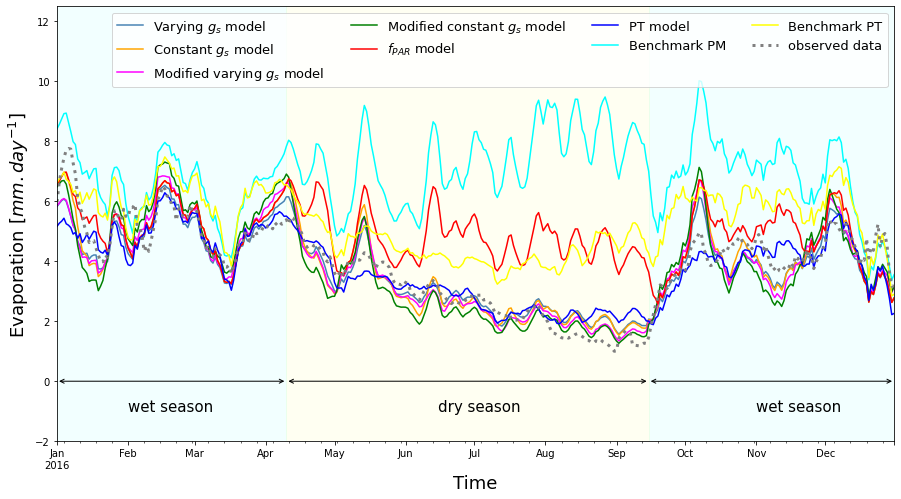

In [43]:
date_beg, date_end = "2016-04-10","2016-09-15"

Columns_name = ["Varying_gS","Constant_gS","Mod_var_gS","Mod_cst_gS","fPAR_PM","PT_model","Bench_PM","Bench_PT","Fe"]
Labels_name = [r"Varying $g_s$ model", r"Constant $g_s$ model", r"Modified varying $g_s$ model",
               r"Modified constant $g_s$ model",r"$f_{PAR}$ model" ,r"PT model", "Benchmark PM","Benchmark PT", "observed data"]
Colors_list = ["steelblue","orange", "magenta", "green","red", "blue" ,"cyan","yellow","grey"]

fig, axe = plt.subplots(figsize = (15,8))

for name_col, labels, colors in zip(Columns_name, Labels_name, Colors_list):
    
    N = TimeSerie_mat[name_col].size
    mov_average = np.zeros((N,))
    for i in range(N):
        size_window_left, size_window_right = min(i,3),min(N - i-1, 3)
        #print(size_window_left, size_window_right)
        sub_set = TimeSerie_mat[name_col][i-size_window_left : i+size_window_right].to_numpy()
        mean_set = np.mean(sub_set)
        mov_average[i] = mean_set
        
    mov_average = pd.DataFrame(mov_average, index = TimeSerie_mat.index)
    mov_average = mov_average.rename(columns = {0:name_col})
    if name_col == "Fe":
        mov_average[name_col].plot(label = labels, color = colors, ls = ":",lw = 3)
    else :
        mov_average[name_col].plot(label = labels, color = colors)
        
axe.legend()

axe.set_ylim([-2,12.5])

# Make the shaded region
plt.fill_between([date_beg, date_end], 15,-5, color='yellow', alpha=.05)
plt.fill_between(["2016-01-01", date_beg], 15, -5, color = 'cyan', alpha = 0.05)
plt.fill_between([date_end, "2016-12-31"], 15, -5, color = 'cyan', alpha = 0.05)

# indicate the seasons by arrows 
plt.annotate(s='', xy=(date_beg,0), xytext=(date_end,0), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=("2016-01-01",0), xytext=(date_beg,0), arrowprops=dict(arrowstyle='<->'))
plt.annotate(s='', xy=(date_end,0), xytext=("2016-12-31",0), arrowprops=dict(arrowstyle='<->'))

axe.text("2016-06-15", -1, "dry season", fontsize=15)
axe.text("2016-02-01", -1, "wet season", fontsize=15)
axe.text("2016-11-01", -1, "wet season", fontsize=15)

axe.set_ylabel(r"Evaporation [$mm.day^{-1}$]", size = 18)
axe.set_xlabel("Time", size = 18)

axe.legend(loc = 1, prop={'size': 13}, ncol = 4)

# plt.savefig(timeSerie_oneSite_oneYear, dpi = 150)

### Compute the model performance 
**For the whole time serie, RMSE and NS for both models**

In [44]:
from collections import defaultdict

Metric_list = [RMSE,NS,RVE,MAE]
Metric_name = ["RMSE","NS","RVE","MAE"]
dic_metric = defaultdict(list)

for metric in Metric_list:
    
    for name_col, labels in zip(Columns_name, Labels_name):
        
        if name_col == "Fe":
            pass
        else:
            metric_res = metric(TimeSerie_mat.Fe.to_numpy(), TimeSerie_mat[name_col].to_numpy())
            dic_metric[name_col].append(metric_res)
            
dic_metric = pd.DataFrame(dic_metric, index = Metric_name)
dic_metric.to_latex(tex_file_whole)
dic_metric

Varying_gS  Constant_gS  Mod_var_gS  Mod_cst_gS   fPAR_PM  PT_model  \
RMSE    0.867409     0.924532    0.931554    1.038747  1.789343  0.899593   
NS      0.709874     0.670403    0.665378    0.583937 -0.234599  0.687945   
RVE     0.024020    -0.002139    0.013361    0.024325 -0.270482  0.021555   
MAE     0.614918     0.692477    0.676997    0.799959  1.406583  0.619385   

      Bench_PM  Bench_PT  
RMSE  3.849381  1.845079  
NS   -4.713745 -0.312710  
RVE  -0.801912 -0.364515  
MAE   3.199727  1.600261

**Dry season period, RMSE and NS for both models**

In [45]:
# dry season :
dic_metric = defaultdict(list)
for metric in Metric_list:
    
    for name_col, labels in zip(Columns_name, Labels_name):
        
        if name_col == "Fe":
            pass
        else:
            metric_res = metric(TimeSerie_mat.Fe[date_beg:date_end].to_numpy(), TimeSerie_mat[name_col][date_beg:date_end].to_numpy())
            dic_metric[name_col].append(metric_res)
            
dic_metric = pd.DataFrame(dic_metric, index = Metric_name)
dic_metric.to_latex(tex_file_dry)
dic_metric

Varying_gS  Constant_gS  Mod_var_gS  Mod_cst_gS   fPAR_PM  PT_model  \
RMSE    0.613282     0.728898    0.626179    0.750989  2.367712  0.635991   
NS      0.746747     0.642259    0.735983    0.620246 -2.774787  0.727644   
RVE    -0.045086    -0.039894   -0.004417    0.069212 -0.735152 -0.058347   
MAE     0.482613     0.573307    0.478669    0.598198  2.084216  0.496328   

       Bench_PM  Bench_PT  
RMSE   5.080072  2.001012  
NS   -16.376981 -1.696088  
RVE   -1.652722 -0.613086  
MAE    4.570540  1.702450

**Wet season period, RMSE and NS for both models**

In [46]:
# wet season :

dic_metric = defaultdict(list)
for metric in Metric_list:
    
    for name_col, labels in zip(Columns_name, Labels_name):
        
        if name_col == "Fe":
            pass
        else:
            metric_res = metric(TimeSerie_mat.Fe[:date_beg and date_end:].to_numpy(), TimeSerie_mat[name_col][:date_beg and date_end:].to_numpy())
            dic_metric[name_col].append(metric_res)
            
dic_metric = pd.DataFrame(dic_metric, index = Metric_name)
dic_metric.to_latex(tex_file_wet)
dic_metric

Varying_gS  Constant_gS  Mod_var_gS  Mod_cst_gS   fPAR_PM  PT_model  \
RMSE    0.770018     0.801993    0.808084    0.918294  1.936702  0.831119   
NS      0.800861     0.783979    0.780686    0.716784 -0.259735  0.768005   
RVE     0.009411    -0.009784    0.007280    0.022225 -0.344705  0.003059   
MAE     0.563843     0.628617    0.597555    0.720772  1.553741  0.585899   

      Bench_PM  Bench_PT  
RMSE  4.116962  1.797729  
NS   -4.692554 -0.085430  
RVE  -0.896827 -0.373457  
MAE   3.389369  1.541070

### Inverse modelling
By doing inverse modeling, we want to investigate the behavior of the varying surface conductance with the "theoretical one"

In [45]:
# compute the stomatas conductances
Var_gs = stress_factor_func(Data.Sws,Res_PM_var[0],Res_PM_var[1])*1/70*100
Mod_var_gs = stress_factor_func(Data.Sws,Res_PM_var_mod[0],Res_PM_var_mod[1])*1/70*100
Theoretical_gs = inv_PM_run(Data)*100

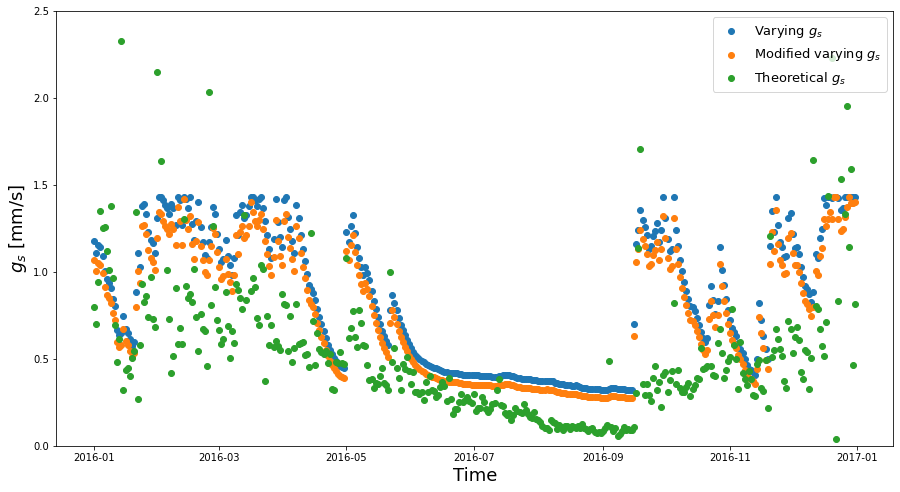

In [46]:
# plot the time series : 
fig, axe =  plt.subplots(figsize = (15,8))
axe.scatter(Data.index, Var_gs, label = r"Varying $g_s$")
axe.scatter(Data.index, Mod_var_gs, label = r"Modified varying $g_s$")
axe.scatter(Data.index, Theoretical_gs, label = r"Theoretical $g_s$")
axe.set_ylim([0,2.5])
axe.set_xlabel("Time", size = 18)
axe.set_ylabel(r"$g_s$ [mm/s]", size = 18)
axe.legend(loc = 1, prop={'size': 13})

plt.savefig(inverseModelling, dpi = 150)

### Influence of the atmospheric forcing over the model behavior

Investigate the influence of some changes in atmospheric forcing over the behavior of the models. Methodology:
1. Select one atmospheric forcing (Air temperature (Ta), Net radiation (Fn), wind speed (Ws) or shear stress (ustar))
2. Modify the dataset to include the changes of the atmospheric forcing
3. Compute the model results 
4. Compute the mean
5. Plot the results

`Data` still contains the 2016 data for Howard Spring

`Res_PM_var` and `Res_PM_cst` still contain the calibrated coefficient of the models

**For the dry season**

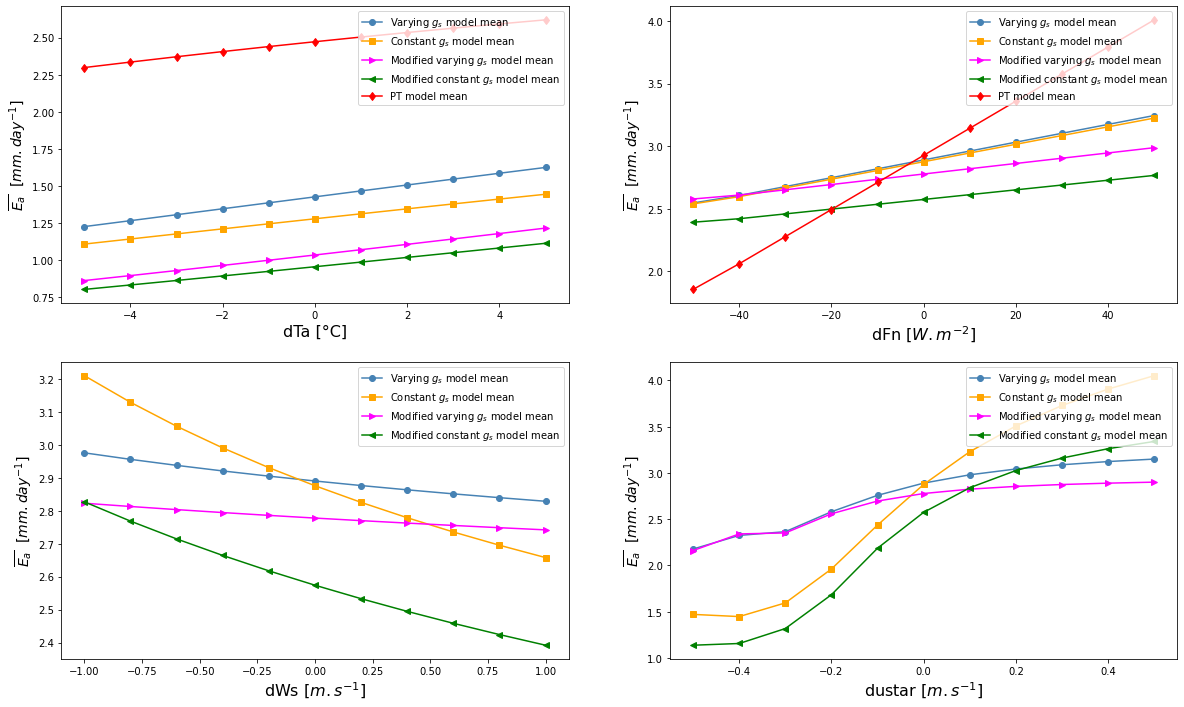

In [47]:
VarInterest = ["Ta", "Fn","Ws","ustar"]
Model_func = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run]
Model_index = ["Var","Cst", "","",""]
Model_plot_label = [r"Varying $g_s$ model", r"Constant $g_s$ model", r"Modified varying $g_s$ model", r"Modified constant $g_s$ model", r"PT model"]
Marker_style = ["o","s", ">", "<", "d"]
colors = ["steelblue","orange", "magenta", "green","red"]
Model_Best_para = [Res_PM_var , Res_PM_cst, Res_PM_var_mod, Res_PM_cst_mod, Res_PT]
rangeDeviation = [1,10,0.2,0.1]
Units = ["[°C]", r"[$W.m^{-2}$]", r"[$m.s^{-1}$]", r"[$m.s^{-1}$]"]

fig, axe = plt.subplots(2,2, figsize = (20,12))

for ax, AtmoVar, unit, DevCondition in zip(axe.flatten(),VarInterest, Units, rangeDeviation):
    
    deviation = np.arange(-5*DevCondition,6*DevCondition,DevCondition)
    
    for func_model, label_graph, indexModel, best_set, marker_style, col in zip( Model_func, Model_plot_label, Model_index, Model_Best_para, Marker_style, colors):
        
        Mean_list = []
        Max_list = []
        Med_list = []
        
        if AtmoVar == "Ta":
            coeff_calib = calibration(Data, func_model, compute_VPD = True)
                                      
        for dev in deviation:
            # data modification
            Data_exp = Data.copy()
            Data_exp[AtmoVar] = Data[AtmoVar]+dev
            Data_exp[Data_exp[AtmoVar] < 0] = 0 #avoid negative values 
            Data_exp = Data_exp[date_beg:date_end] # select the dry season
            
            # model computation
            if (AtmoVar == "Ws" and func_model == PT_run) or (AtmoVar == "ustar" and func_model == PT_run):
                pass
            
            if AtmoVar == "Ta":
                ModelRes = func_model(Data_exp, coeff_calib[0], coeff_calib[1], compute_VPD = True)*60*60*24
            else:
                ModelRes = func_model(Data_exp, best_set[0],best_set[1])*60*60*24
                
            MeanRes = ModelRes[~np.isnan(ModelRes)].mean()
            #MaxRes = ModelRes[~np.isnan(ModelRes)].max()
            MedRes = np.median(ModelRes[~np.isnan(ModelRes)])
            
            # compute the mean of the results
            Mean_list.append(MeanRes)
            #Max_list.append(MaxRes)
            Med_list.append(MedRes)
        if (AtmoVar == "Ws" and func_model == PT_run) or (AtmoVar == "ustar" and func_model == PT_run):
            pass
        
        else:
            
            ax.plot(deviation, Mean_list, marker = marker_style, label = label_graph+" mean", color = col)
            #ax.plot(deviation, Max_list, marker = marker_style, label = label_graph+" max", ls = ":")
            #ax.plot(deviation, Med_list, marker = marker_style, label = label_graph+ " median", ls = "--", color = col)
            ax.set_xlabel("d"+AtmoVar+" "+unit, size = 16)
            ax.set_ylabel(r"$\overline{E_a}$  $[mm.day^{-1}]$", size = 14)
            ax.legend(loc = 1,prop={'size': 10})
        
plt.savefig(Influence_atmo_E_dry, dpi = 150)

**For the wet season**

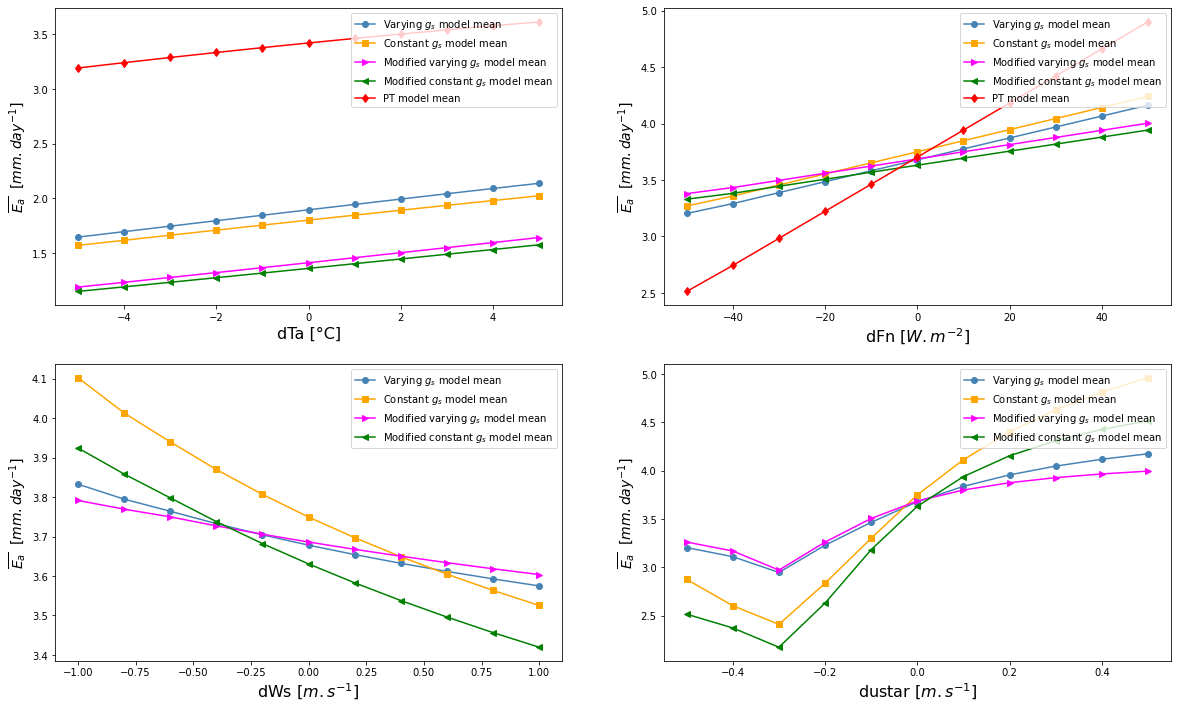

In [48]:
VarInterest = ["Ta", "Fn","Ws","ustar"]
Model_func = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run]
Model_index = ["Var","Cst", "","",""]
Model_plot_label = [r"Varying $g_s$ model", r"Constant $g_s$ model", r"Modified varying $g_s$ model", r"Modified constant $g_s$ model", r"PT model"]
Marker_style = ["o","s", ">", "<", "d"]
colors = ["steelblue","orange", "magenta", "green","red"]
Model_Best_para = [Res_PM_var , Res_PM_cst, Res_PM_var_mod, Res_PM_cst_mod, Res_PT]
rangeDeviation = [1,10,0.2,0.1]
Units = ["[°C]", r"[$W.m^{-2}$]", r"[$m.s^{-1}$]", r"[$m.s^{-1}$]"]

fig, axe = plt.subplots(2,2, figsize = (20,12))

for ax, AtmoVar, unit, DevCondition in zip(axe.flatten(),VarInterest, Units, rangeDeviation):
    
    deviation = np.arange(-5*DevCondition,6*DevCondition,DevCondition)
    
    for func_model, label_graph, indexModel, best_set, marker_style, col in zip( Model_func, Model_plot_label, Model_index, Model_Best_para, Marker_style, colors):
        
        Mean_list = []
        Max_list = []
        Med_list = []
        
        if AtmoVar == "Ta":
            coeff_calib = calibration(Data, func_model, compute_VPD = True)
                                      
        for dev in deviation:
            # data modification
            Data_exp = Data.copy()
            Data_exp[AtmoVar] = Data[AtmoVar]+dev
            Data_exp[Data_exp[AtmoVar] < 0] = 0 #avoid negative values 
            Data_exp = Data_exp[:date_beg and date_end:] # select the dry season
            
            # model computation
            if AtmoVar == "Ta":
                ModelRes = func_model(Data_exp, coeff_calib[0], coeff_calib[1], compute_VPD = True)*60*60*24
            else:
                ModelRes = func_model(Data_exp, best_set[0],best_set[1])*60*60*24
                
            MeanRes = ModelRes[~np.isnan(ModelRes)].mean()
            #MaxRes = ModelRes[~np.isnan(ModelRes)].max()
            MedRes = np.median(ModelRes[~np.isnan(ModelRes)])
            
            # compute the mean of the results
            Mean_list.append(MeanRes)
            #Max_list.append(MaxRes)
            Med_list.append(MedRes)
        if (AtmoVar == "Ws" and func_model == PT_run) or (AtmoVar == "ustar" and func_model == PT_run):
            pass
        else:
            ax.plot(deviation, Mean_list, marker = marker_style, label = label_graph+" mean", color = col)
            #ax.plot(deviation, Max_list, marker = marker_style, label = label_graph+" max", ls = ":")
            #ax.plot(deviation, Med_list, marker = marker_style, label = label_graph+ " median", ls = "--", color = col)
            ax.set_xlabel("d"+AtmoVar+" "+unit, size = 16)
            ax.set_ylabel(r"$\overline{E_a}$  $[mm.day^{-1}]$", size = 14)
            ax.legend(loc = 1,prop={'size': 10})
plt.savefig(Influence_atmo_E_wet, dpi = 150)

#### Graphs with relative changes instead of absolute number

**For the dry season**

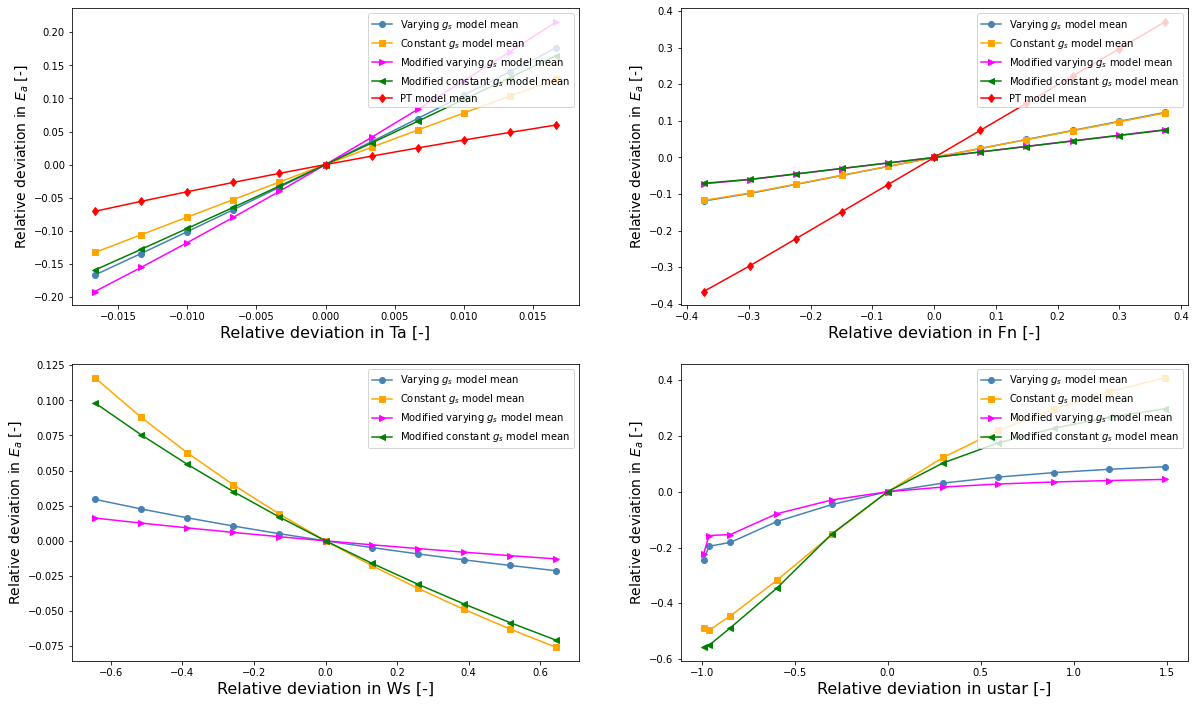

In [52]:
VarInterest = ["Ta", "Fn","Ws","ustar"]
Model_func = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run]
Model_index = ["Var","Cst", "","",""]
Model_plot_label = [r"Varying $g_s$ model", r"Constant $g_s$ model", r"Modified varying $g_s$ model", r"Modified constant $g_s$ model", r"PT model"]
Marker_style = ["o","s", ">", "<", "d"]
colors = ["steelblue","orange", "magenta", "green","red"]
Model_Best_para = [Res_PM_var , Res_PM_cst, Res_PM_var_mod, Res_PM_cst_mod, Res_PT]
rangeDeviation = [1,10,0.2,0.1]
Units = ["[°C]", r"[$W.m^{-2}$]", r"[$m.s^{-1}$]", r"[$m.s^{-1}$]"]

fig, axe = plt.subplots(2,2, figsize = (20,12))

for ax, AtmoVar, unit, DevCondition in zip(axe.flatten(),VarInterest,Units,rangeDeviation):
    
    deviation = np.arange(-5*DevCondition,6*DevCondition,DevCondition)
    
    for func_model, label_graph, indexModel, best_set, marker_style, col in zip( Model_func, Model_plot_label, Model_index, Model_Best_para, Marker_style, colors):
        
        Mean_list = []
        Max_list = []
        Med_list = []
        
        Rel_dev = []
        
        
        
        if AtmoVar == "Ta":
            Benchmark_mean = 60*60*24*func_model(Data[date_beg:date_end], best_set[0],best_set[1], compute_VPD = True).mean()
            Benchmark_med = 60*60*24*np.median(func_model(Data[date_beg:date_end], best_set[0],best_set[1], compute_VPD = True))
            coeff_calib = calibration(Data, func_model, compute_VPD = True)
            
        else:
            Benchmark_mean = 60*60*24*func_model(Data[date_beg:date_end], best_set[0],best_set[1]).mean()
            Benchmark_med = 60*60*24*np.median(func_model(Data[date_beg:date_end], best_set[0],best_set[1]))
            
        for dev in deviation:

            # data modification
            Data_exp = Data.copy()
            Data_exp[AtmoVar] = Data[AtmoVar]+dev
            Data_exp[Data_exp[AtmoVar] < 0] = 0 #avoid negative values 
            Data_exp = Data_exp[date_beg:date_end] # select the dry season
            
            relDev = (Data_exp[AtmoVar].sum() - Data[date_beg:date_end][AtmoVar].sum())/Data[date_beg:date_end][AtmoVar].sum()
            Rel_dev.append(relDev)
            
            # model computation
            
            if AtmoVar == "Ta":
                ModelRes = func_model(Data_exp, best_set[0],best_set[1], compute_VPD = True)*60*60*24
            else:
                ModelRes = func_model(Data_exp, best_set[0],best_set[1])*60*60*24
                
            MeanRes = ModelRes[~np.isnan(ModelRes)].mean()
            #MaxRes = ModelRes[~np.isnan(ModelRes)].max()
            MedRes = np.median(ModelRes[~np.isnan(ModelRes)])
            
            # compute the mean of the results
            Mean_list.append((MeanRes-Benchmark_mean)/Benchmark_mean)
            #Max_list.append(MaxRes)
            Med_list.append((MedRes-Benchmark_med)/Benchmark_med)
            
        if (AtmoVar == "Ws" and func_model == PT_run) or (AtmoVar == "ustar" and func_model == PT_run):
            pass
        else:
            ax.plot(Rel_dev, Mean_list, marker = marker_style, label = label_graph+" mean", color = col)
            #ax.plot(deviation, Max_list, marker = marker_style, label = label_graph+" max", ls = ":")
            #ax.plot(Rel_dev, Med_list, marker = marker_style, label = label_graph+ " median", ls = "--", color = col)
            ax.set_xlabel("Relative deviation in "+AtmoVar+" [-]", size = 16)
            ax.set_ylabel(r"Relative deviation in $E_a$ [-]", size = 14)
            ax.legend(loc = 1,prop={'size': 10})
plt.savefig(Influence_atmo_rel_dry, dpi = 150)

**For the wet period**

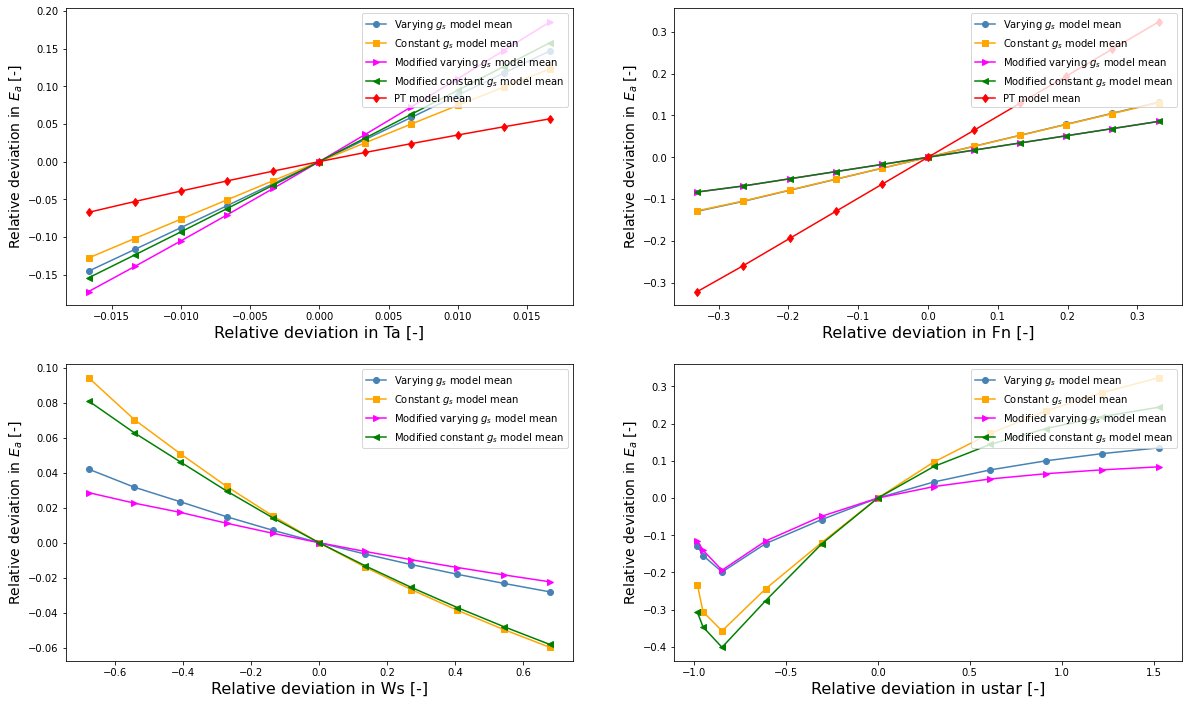

In [51]:
VarInterest = ["Ta", "Fn","Ws","ustar"]
Model_func = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run]
Model_index = ["Var","Cst", "","",""]
Model_plot_label = [r"Varying $g_s$ model", r"Constant $g_s$ model", r"Modified varying $g_s$ model", r"Modified constant $g_s$ model", r"PT model"]
Marker_style = ["o","s", ">", "<", "d"]
colors = ["steelblue","orange", "magenta", "green","red"]
Model_Best_para = [Res_PM_var , Res_PM_cst, Res_PM_var_mod, Res_PM_cst_mod, Res_PT]
rangeDeviation = [1,10,0.2,0.1]
Units = ["[°C]", r"[$W.m^{-2}$]", r"[$m.s^{-1}$]", r"[$m.s^{-1}$]"]

fig, axe = plt.subplots(2,2, figsize = (20,12))

for ax, AtmoVar, DevCondition in zip(axe.flatten(),VarInterest,rangeDeviation):
    
    deviation = np.arange(-5*DevCondition,6*DevCondition,DevCondition)
    
    for func_model, label_graph, indexModel, best_set, marker_style, col in zip( Model_func, Model_plot_label, Model_index, Model_Best_para, Marker_style, colors):
        
        Mean_list = []
        Max_list = []
        Med_list = []
        
        Rel_dev = []
        
        
        
        if AtmoVar == "Ta":
            Benchmark_mean = 60*60*24*func_model(Data[:date_beg and date_end:], best_set[0],best_set[1], compute_VPD = True).mean()
            Benchmark_med = 60*60*24*np.median(func_model(Data[:date_beg and date_end:], best_set[0],best_set[1], compute_VPD = True))
            coeff_calib = calibration(Data, func_model, compute_VPD = True)
            
        else:
            Benchmark_mean = 60*60*24*func_model(Data[:date_beg and date_end:], best_set[0],best_set[1]).mean()
            Benchmark_med = 60*60*24*np.median(func_model(Data[:date_beg and date_end:], best_set[0],best_set[1]))
            
        for dev in deviation:

            # data modification
            Data_exp = Data.copy()
            Data_exp[AtmoVar] = Data[AtmoVar]+dev
            Data_exp[Data_exp[AtmoVar] < 0] = 0 #avoid negative values 
            Data_exp = Data_exp[:date_beg and date_end:] # select the dry season
            
            relDev = (Data_exp[AtmoVar].sum() - Data[:date_beg and date_end:][AtmoVar].sum())/Data[:date_beg and date_end:][AtmoVar].sum()
            Rel_dev.append(relDev)
            
            # model computation
            
            if AtmoVar == "Ta":
                ModelRes = func_model(Data_exp, best_set[0],best_set[1], compute_VPD = True)*60*60*24
            else:
                ModelRes = func_model(Data_exp, best_set[0],best_set[1])*60*60*24
                
            MeanRes = ModelRes[~np.isnan(ModelRes)].mean()
            #MaxRes = ModelRes[~np.isnan(ModelRes)].max()
            MedRes = np.median(ModelRes[~np.isnan(ModelRes)])
            
            # compute the mean of the results
            Mean_list.append((MeanRes-Benchmark_mean)/Benchmark_mean)
            #Max_list.append(MaxRes)
            Med_list.append((MedRes-Benchmark_med)/Benchmark_med)
            
        if (AtmoVar == "Ws" and func_model == PT_run) or (AtmoVar == "ustar" and func_model == PT_run):
            pass
        else:
            ax.plot(Rel_dev, Mean_list, marker = marker_style, label = label_graph+" mean", color = col)
            #ax.plot(deviation, Max_list, marker = marker_style, label = label_graph+" max", ls = ":")
            #ax.plot(Rel_dev, Med_list, marker = marker_style, label = label_graph+ " median", ls = "--", color = col)
            ax.set_xlabel("Relative deviation in "+AtmoVar+" [-]", size = 16)
            ax.set_ylabel(r"Relative deviation in $E_a$ [-]", size = 14)
            ax.legend(loc = 1,prop={'size': 10})
plt.savefig(Influence_atmo_rel_wet, dpi = 150)

#### Investigate the influence of wind speed on $E_a$
From the previous analysis, it happens that $E_a$ is a decreasing function of wind speed which can seems conter-intuitive. More wind means more advection and higher vapor pressure saturation deficit, so more evapo-transpiration. This section mathematically investigate the relation between wind speed and $E_a$

In [138]:
delta_func(Data.Ta)

array([231.25247677, 236.55687243, 232.441429  , 231.57815489,
       238.55508125, 240.27447136, 242.73271032, 217.90762955,
       223.98548928, 231.3087916 , 240.27093959, 240.82052837,
       234.03351371, 214.63890456, 235.23706485, 243.14811303,
       247.83309972, 253.3890565 , 249.79152277, 226.37574039,
       204.95846075, 231.01358946, 245.50095476, 228.53722848,
       230.4687907 , 240.41843108, 251.74830886, 243.84675748,
       239.06110196, 227.08537522, 208.67822048, 216.2349691 ,
       219.35742556, 227.02461647, 226.54007137, 217.78250933,
       230.47593828, 225.1219664 , 233.67341223, 228.41599022,
       216.14381274, 234.34386866, 233.89912658, 228.46318038,
       240.66973204, 228.57890759, 237.48966206, 247.47990405,
       228.62064976, 209.82938567, 236.04560412, 252.22427903,
       249.7951044 , 245.11860451, 216.38132256, 222.36006254,
       224.01702252, 219.45281205, 230.67491813, 240.7825006 ,
       240.36355979, 243.71865077, 224.67029558, 227.83

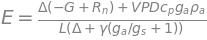

In [48]:
eq_PM_g

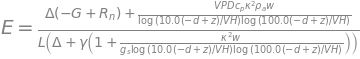

In [64]:
eq_PM_g.subs({g_a:g_a.definition.expr, r_a:r_a.definition.expr, d:d.definition.expr, z_om:z_om.definition.expr,
              z_oh:z_oh.definition.expr,VH:VH.definition.expr})

In [96]:
from sympy import latex
from sympy import N
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown

def plot_expr2(xvar_min_max, yldata, yllabel=None, yrdata=None,
               yrlabel='', clf=True, npoints=100, ylmin=None, ylmax=None,
               yrmin=None, yrmax=None, xlabel=None,
               colors=None,
               loc_legend_left='best', loc_legend_right='right',
               linestylesl=['-', '--', '-.', ':'],
               linestylesr=['-', '--', '-.', ':'],
               fontsize=None, fontsize_ticks=None, fontsize_labels=None,
               fontsize_legend=None,
               fig1=None, **args):
    '''
    Plot expressions as function of xvar from xmin to xmax.

    **Examples:**

    from essm.variables import Variable
    from essm.variables.physics.thermodynamics import T_a
    from essm.equations.physics.thermodynamics import eq_nua, eq_ka
    vdict = Variable.__defaults__.copy()
    expr = eq_nua.subs(vdict)
    exprr = eq_ka.subs(vdict)
    xvar = T_a
    yldata = [(expr.rhs, 'full'), (expr.rhs/2, 'half')]
    yrdata = exprr
    plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a), yrdata=yrdata)
    plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a),
               yrdata=[(1/exprr.lhs, 1/exprr.rhs)],
               loc_legend_right='lower right')
    plot_expr2((T_a, 273, 373), expr)
    plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a))
    '''
    (xvar, xmin, xmax) = xvar_min_max
    if not colors:
        if yrdata is not None:
            colors = ['black', 'blue', 'red', 'green']
        else:
            colors = ['blue', 'black', 'red', 'green']
    if fontsize:
        fontsize_labels = fontsize
        fontsize_legend = fontsize
        fontsize_ticks = fontsize
    if not fig1:
        plt.close
        plt.clf
        fig = plt.figure(**args)
    else:
        fig = fig1
    if hasattr(xvar, 'definition'):
        unit1 = derive_unit(xvar)
        if unit1 != 1:
            strunit = ' (' + markdown(unit1) + ')'
        else:
            strunit = ''
        if not xlabel:
            xlabel = '$'+latex(xvar)+'$'+ strunit
    else:
        if not xlabel:
            xlabel = xvar
    if hasattr(yldata, 'lhs'):
        yldata = (yldata.rhs, yldata.lhs)
    if not yllabel:
        if type(yldata) is tuple:
            yllabel = yldata[1]
        else:
            try:
                yllabel = yldata[0][1]
            except Exception as e1:
                print(e1)
                print('yldata must be equation or list of (expr, name) tuples')

    if type(yllabel) is not str:
        unit1 = derive_unit(yllabel)
        if unit1 != 1:
            strunit = ' (' + markdown(unit1) + ')'
        else:
            strunit = ''

        yllabel = '$'+latex(yllabel)+'$'+ strunit
    if type (yldata) is not list and type(yldata) is not tuple:
        # If only an expression given
        yldata = [(yldata, '')]
    if type(yldata[0]) is not tuple:
        yldata = [yldata]
    if yrdata is not None:
        if yrlabel == '':
            if hasattr(yrdata, 'lhs'):
                yrlabel = yrdata.lhs
        if type (yrdata) is not list and type(yrdata) is not tuple:
            # If only an expression given
            yrdata = [yrdata]
    if type(yrlabel) is not str:
        yrlabel = '$'+latex(yrlabel)+'$'+ ' (' + markdown(derive_unit(yrlabel)) + ')'

    xstep = (xmax - xmin)/npoints
    xvals = arange(xmin, xmax, xstep)

    ax1 =  fig.add_subplot(1, 1, 1)
    if yrdata is not None:
        color = colors[0]
    else:
        color = 'black'
    if ylmin:    ax1.set_ylim(ymin=float(ylmin))
    if ylmax:    ax1.set_ylim(ymax=float(ylmax))
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(yllabel, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    i = 0
    for (expr1, y1var) in yldata:
        linestyle = linestylesl[i]
        if yrdata is None:
            color = colors[i]
        i= i + 1
        try:
            y1vals = [expr1.subs(xvar, dummy).n() for dummy in xvals]
            ax1.plot(xvals, y1vals, color=color, linestyle=linestyle, label=y1var)
        except Exception as e1:
            print([expr1.subs(xvar, dummy) for dummy in xvals])
            print(e1)
    if i > 1 or yrdata is not None:
        plt.legend(loc=loc_legend_left, fontsize=fontsize_legend)

    if yrdata is not None:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = colors[1]
        ax2.set_ylabel(yrlabel, color=color)
        i = 0

        for item in yrdata:
            if type(item) is tuple:   # if item is tuple
                (expr2, y2var) = item
            else:
                try:
                    (y2var, expr2) = (item.lhs, item.rhs)
                except Exception as e1:
                    print(e1)
                    print('yrdata must be a list of equations or tuples (var, expr)')
                    return
            linestyle = linestylesr[i]
            i = i + 1
            try:
                y2vals = [expr2.subs(xvar, dummy).n() for dummy in xvals]
                ax2.plot(xvals, y2vals, color=color, linestyle=linestyle, label=y2var)
            except Exception as e1:
                print(expr2)
                print([expr2.subs(xvar, dummy).n() for dummy in xvals])
                print(e1)

            if not yrlabel:
                if hasattr(yrdata[0], 'lhs'):
                    yrlabel = yrdata[0].lhs

        if type(yrlabel) is not str:
            yrlabel = '$'+latex(yrlabel)+'$'+ ' (' + markdown(derive_unit(yrlabel)) + ')'
        ax2.tick_params(axis='y', labelcolor=color)
        if yrmin:    ax2.set_ylim(ymin=float(yrmin))
        if yrmax:    ax2.set_ylim(ymax=float(yrmax))
        leg=ax2.legend(loc=loc_legend_right, fontsize=fontsize_legend)
        ax2.add_artist(leg);
        for item in ([ax2.xaxis.label, ax2.yaxis.label]):
            item.set_fontsize(fontsize_labels)
        ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)

    for item in ([ax1.xaxis.label, ax1.yaxis.label]):
        item.set_fontsize(fontsize_labels)
    ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    return fig

In [97]:
# define new classes of equations: 

class eq_VH(Equation):
    """Formal definition of VH"""
    expr = Eq(VH,z/(0.66+0.1*exp(kappa*w/u_star)))
    
class eq_zom(Equation):
    """Formal definition of zom"""
    expr = Eq(z_om,0.1*eq_VH.rhs)

class eq_zoh(Equation):
    """Formal definition of zoh"""
    expr = Eq(z_oh,0.1*eq_zom.rhs)
    
class eq_d(Equation):
    """Formal definition of d"""
    expr = Eq(d,0.66*eq_VH.rhs)

class eq_ga(Equation):
    """Formal definition of ga"""
    expr = Eq(g_a,(w*kappa**2)/(log((z-eq_d.rhs)/eq_zom.rhs)*log((z-eq_d.rhs)/eq_zoh.rhs)))

class eq_PM_formal(Equation):
    """Formal equation of PM"""
    expr = Eq(E,(Delta*(Rn-G)+rho_a*c_p*VPD*eq_ga.rhs)/(L*(Delta+gamma*(1+eq_ga.rhs/g_s))))

vdic = {Delta:0.2, G:25, Rn:300, VPD:10, L:L.definition.default, gamma: gamma.definition.default, c_p: c_p.definition.default,
       rho_a:rho_a.definition.default, kappa:kappa.definition.default, u_star:0.2, g_s:0.0014, z:23}

expr = eq_PM_formal.rhs.subs(vdic)

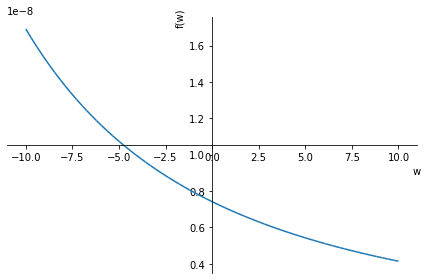

In [115]:
from sympy.plotting import plot
plot(diff(eq_PM_formal.rhs,w).subs(vdic))

In [ ]:
from sympy.utilities.lambdify import lambdify
delta = np.linspace(0.2,10,100)
vpd = np.linspace(250,1550,100)

delta_mesh, vpd_mesh = np.meshgrid(delta,vpd)

heatmap = np.zeros(delta_mesh.shape)

for i in range(delta_mesh.shape[0]):
    if i % 20 == 0:
        print(i)
    for j in range(delta_mesh.shape[1]):
        vdic = {Delta:delta_mesh[i,j], G:25, Rn:400, VPD:vpd_mesh[i,j], L:L.definition.default, gamma: gamma.definition.default, c_p: c_p.definition.default,
           rho_a:rho_a.definition.default, kappa:kappa.definition.default, u_star:0.2, g_s:0.0014, z:23}
        deriv = lambdify(w, diff(eq_PM_formal.rhs,w).subs(vdic))
        
        heatmap[i,j] = deriv(1)# what happen with wind speed of 1m/s

0
20
40


In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(delta_mesh, vpd_mesh, heatmap)

ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$VPD$')
ax.set_zlabel(r'$dE_a/dW$')

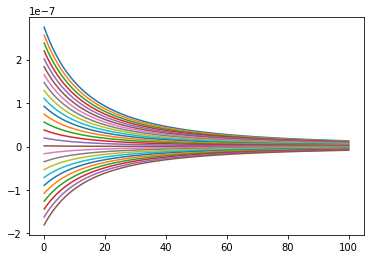

In [141]:
from sympy.utilities.lambdify import lambdify

Rn_List = np.arange(250,1550,50)

for rn in Rn_List :
    
    vdic = {Delta:5, G:25, Rn:400, VPD:rn, L:L.definition.default, gamma: gamma.definition.default, c_p: c_p.definition.default,
           rho_a:rho_a.definition.default, kappa:kappa.definition.default, u_star:0.2, g_s:0.0014, z:23}
    
    deriv = lambdify(w, diff(eq_PM_formal.rhs,w).subs(vdic))
    
    W = np.arange(0.1,100,0.01)
    plt.plot(W,deriv(W))

In [122]:
vdic = {Delta:0.2, G:25, Rn:400, VPD:10, L:L.definition.default, gamma: gamma.definition.default, c_p: c_p.definition.default,
       rho_a:rho_a.definition.default, kappa:kappa.definition.default, u_star:0.2, g_s:0.0014, z:23}

class dE_dW(Variable):
    """Wind Speed derivative"""
    unit= meter/second
    
class eq_dE_dW(Equation):
    """equation dE/dW"""
    expr = Eq(dE_dW,diff(eq_PM_formal.rhs,w).subs(vdic))

eq_dE_dW
# fig=plot_expr2((w, 0, 10), eq_PM_formal.subs(vdic))

/opt/conda/lib/python3.8/site-packages/essm/variables/_core.py:89: UserWarning: "__main__:dE_dW" will be overridden by "__main__:<class '__main__.dE_dW'>"
  instance[expr] = instance


ValueError: Dimension of "8044.78571428571*w/(log(0.434782608695652*(23 - 15.18/(0.1*exp(2.05*w) + 0.66))*(0.1*exp(2.05*w) + 0.66))*log(4.34782608695652*(23 - 15.18/(0.1*exp(2.05*w) + 0.66))*(0.1*exp(2.05*w) + 0.66)))" is Dimension(length/time), but it should be the same as 67.2000000000000, i.e. Dimension(1)

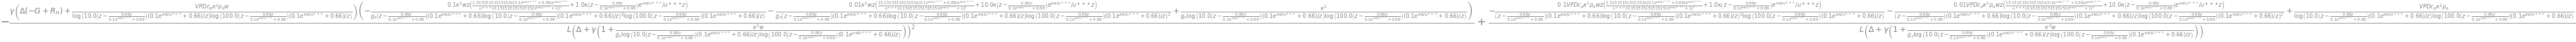

In [101]:
from sympy import diff
diff(eq_PM_formal.rhs,w)

### Sensitivity analysis of the different models
Aim : investigate the sensitivity of the models to their different meta-parameters ($\theta_3$ and $\theta_4$). Methodology : 
1. Construct the meshed matric ($\theta_3$, $\theta_4$) and ($\theta_3$, $g_s$)
2. Evaluate the models on the meshgrid (RMSE)
3. Plot the results (heat maps with contour plots)

**Construct the mesh grids**

In [49]:
N = 100
#theta_3 = np.linspace(0.1, 1, N)
#theta_4 = np.linspace(0.001, 0.1, N)
theta_3 = np.linspace(0, 1, N)
theta_4 = np.linspace(0, 0.2, N)

Theta_3, Theta_4 = np.meshgrid(theta_3, theta_4)

**Evaluate the models on the different meshgrids**

In [50]:
ListModel = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run]
Mat_agg = []

for model_func in ListModel :
    
    Heat_Perf = np.zeros(Theta_3.shape)
    
    for i in range(Theta_3.shape[0]):
        if i % 50 == 0:
            print(i)
        for j in range(Theta_3.shape[1]):
        
            model_run = model_func(Data, Theta_3[i,j],Theta_4[i,j])
            RMSE_case = RMSE(Data.Fe.to_numpy()*60*60*24, model_run*60*60*24)
            Heat_Perf[i,j] = RMSE_case
            
    Mat_agg.append(Heat_Perf)

0
50
0
50
0
50
0
50
0
50


**Plot the results**

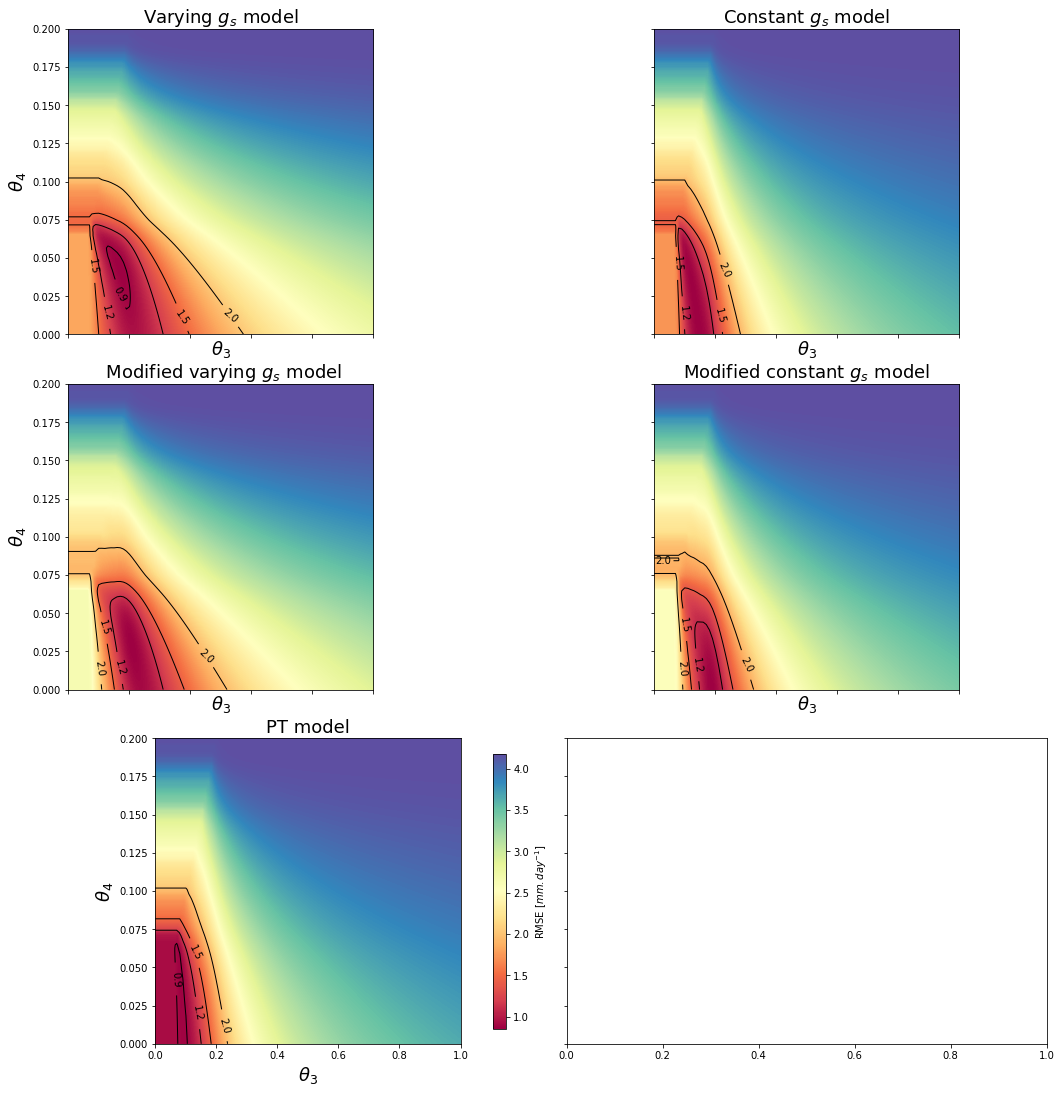

In [51]:
ListLabel = [r"Varying $g_s$ model", r"Constant $g_s$ model",r" Modified varying $g_s$ model",r"Modified constant $g_s$ model", "PT model"]

#constrained_layout=True,
fig, axes = plt.subplots(3,2, figsize = (15,15),constrained_layout=True, sharex = True, sharey = True)
fig.delaxes(axe[2,1])

for model_label, ax, resMat in zip(ListLabel, axes.flatten(), Mat_agg):
    
    im = ax.imshow(resMat, interpolation='bilinear', cmap="Spectral",origin='lower', extent=[0, 1, 0, 0.2 ])
                #vmax=1, vmin=-abs(resMat).max())
               #vmax=1, vmin=-abs(resMat).max())
    
    # set the contourlines of the plots
    
    CS = ax.contour(Theta_3, Theta_4,resMat,levels = [0.9,1.2,1.5,2.0],colors=('k',),linestyles=('-',),linewidths=(1,))
    
    fmt = {}
    strs = ['0.9', '1.2', '1.5', '2.0']
    for l, s in zip(CS.levels, strs):
        fmt[l] = s
        
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    
    ax.set_title(model_label, size = 18)
    ax.set_xlabel(r"$\theta_3$", size = 18)
    #ax.set_ylabel(r"$g_s$", size = 18)
    ax.set_aspect(5)

# tight layout for the colorbar
fig.colorbar(im, ax=ax, shrink=0.9, label = r"RMSE $[mm.day^{-1}]$")
axes[0,0].set_ylabel(r"$\theta_4$", size = 18)
axes[1,0].set_ylabel(r"$\theta_4$", size = 18)
axes[2,0].set_ylabel(r"$\theta_4$", size = 18)

plt.savefig(sensitivity_parameters, dpi = 150)

## One site, different years
Data from Howard Springs, for year 2002 to 2019. Method : 
1. Create data set with all input data from 2002 to 2019, daily time scale
2. Randomly draw the start and end year of the period assessment
3. Calibrate both models for this period 
4. Compute the RMSE and NS (whole time period)
5. Do a statistical test : varying g_s performs better than constant g_s ?

The aim of the experiment is to see wether the first results found in the previous experiment are universal or was only due to experime

In [53]:
Data_full = DataChose(ds,"2016-2018",fPAR_data_process(fPAR_files[3],dates_fPAR),sel_period_flag = False)

In [55]:
RMSE_mat = np.zeros((1000,6)) # store the RMSE results of both models var, cst, var_mod, cst_mod, PT, PM
RVE_mat = np.zeros((1000,6))
Coeff_mat_var = np.zeros((1000,2)) # store theta_3, theta_4 coefficients
Coeff_mat_cst = np.zeros((1000,2))

Coeff_mat_var_mod = np.zeros((1000,2)) # store theta_3, theta_4 coefficients
Coeff_mat_cst_mod = np.zeros((1000,2))

Coeff_mat_PT = np.zeros((1000,2)) # store theta_3, theta_4 coefficients

model_list = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run, PM_run_classic]

storage_list = [Coeff_mat_var,Coeff_mat_cst,Coeff_mat_var_mod,Coeff_mat_cst_mod,Coeff_mat_PT,""]

index_list = [0,1,2,3,4,5]

Bounds = [[(0.1,1),(0,0.1)],[(0.1,1),(0,0.1)],[(0.1,1),(0,0.1)],[(0.1,1),(0,0.1)],[(0.010,0.13),(0,0.075)],""]

for i in range(1000):
    if i % 100 == 0:
        print(f"{i} / 1000")
    year_start, year_stop = np.random.randint(2002,2020),np.random.randint(2002,2020)
    
    if year_start > year_stop:
        year_start, year_stop = year_stop, year_start
    
    Data = Data_full[str(year_start):str(year_stop)]
    
    for model, mat_store, index, spec_bounds in zip(model_list, storage_list, index_list, Bounds):
        
        if model != PM_run_classic:
            coeff_calib = calibration(Data,model, bounds = spec_bounds)
            TimeSerie = model(Data, coeff_calib[0], coeff_calib[1])
            mat_store[i,0] = coeff_calib[0]
            mat_store[i,1] = coeff_calib[1]
            
        else :
            TimeSerie = model(Data)
            
        RMSE_mat[i,index] = RMSE(Data.Fe.to_numpy()*60*60*24, TimeSerie*60*60*24)
        RVE_mat[i,index] = RVE(Data.Fe.to_numpy()*60*60*24, TimeSerie*60*60*24)

0 / 500
100 / 500
200 / 500
300 / 500
400 / 500


NameError: name 'RMSE_mat' is not defined

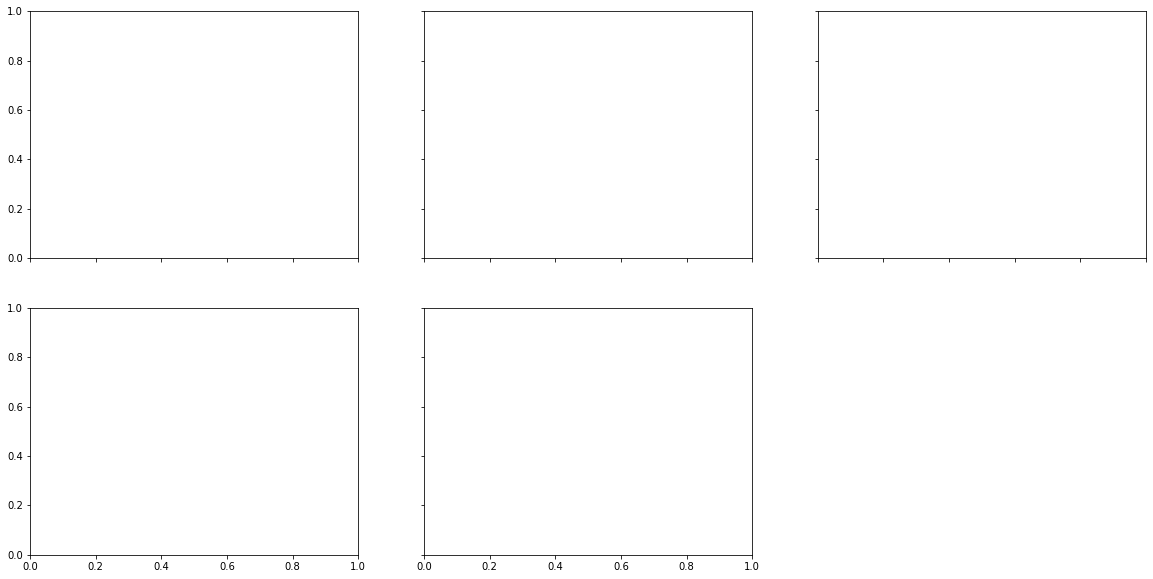

In [150]:
fig, axe = plt.subplots(2,3,figsize = (20,10), sharex = True, sharey = True)
bins_bound = np.arange(0.75,2.5,0.05)
ListLabel = [r"Varying $g_s$ model", r"Constant $g_s$ model",r" Modified varying $g_s$ model",r"Modified constant $g_s$ model", "PT model"]
fig.delaxes(axe[1,2])

for i, ax, title in zip(range(6), axe.flatten(), ListLabel):
    ax.hist(RMSE_mat[:,i],bins= bins_bound)
    ax.set_title(title, size = 18)
    ax.axvline(RMSE_mat[:,i].mean(), ls = ":")
    ax2 = ax.twiny()
    ax2.hist(RVE_mat[:,i], bins = bins_bound)
    ax2.axvline(RVE_mat[:,i].mean(), ls = ":")

axe[0,0].set_ylabel("Number of observations", size = 18)
axe[1,0].set_ylabel("Number of observations", size = 18)

axe[1,0].set_xlabel("RMSE", size = 18)
axe[1,1].set_xlabel("RMSE", size = 18)
axe[1,2].set_xlabel("RMSE", size = 18)



plt.savefig(statistical_assessment, dpi = 105)

## Different sites

In this experiment, we want to compare the performance of both models on 5 different study sites. Methodology:
1. Select one study site
2. Select one year 
3. Calibrate the models 
4. Compute the best model runs
5. Compute the RMSE
6. Plot it

------------------- Ade -----------------
------------------- Dal -----------------
------------------- Dry -----------------
------------------- How -----------------
------------------- Stu -----------------


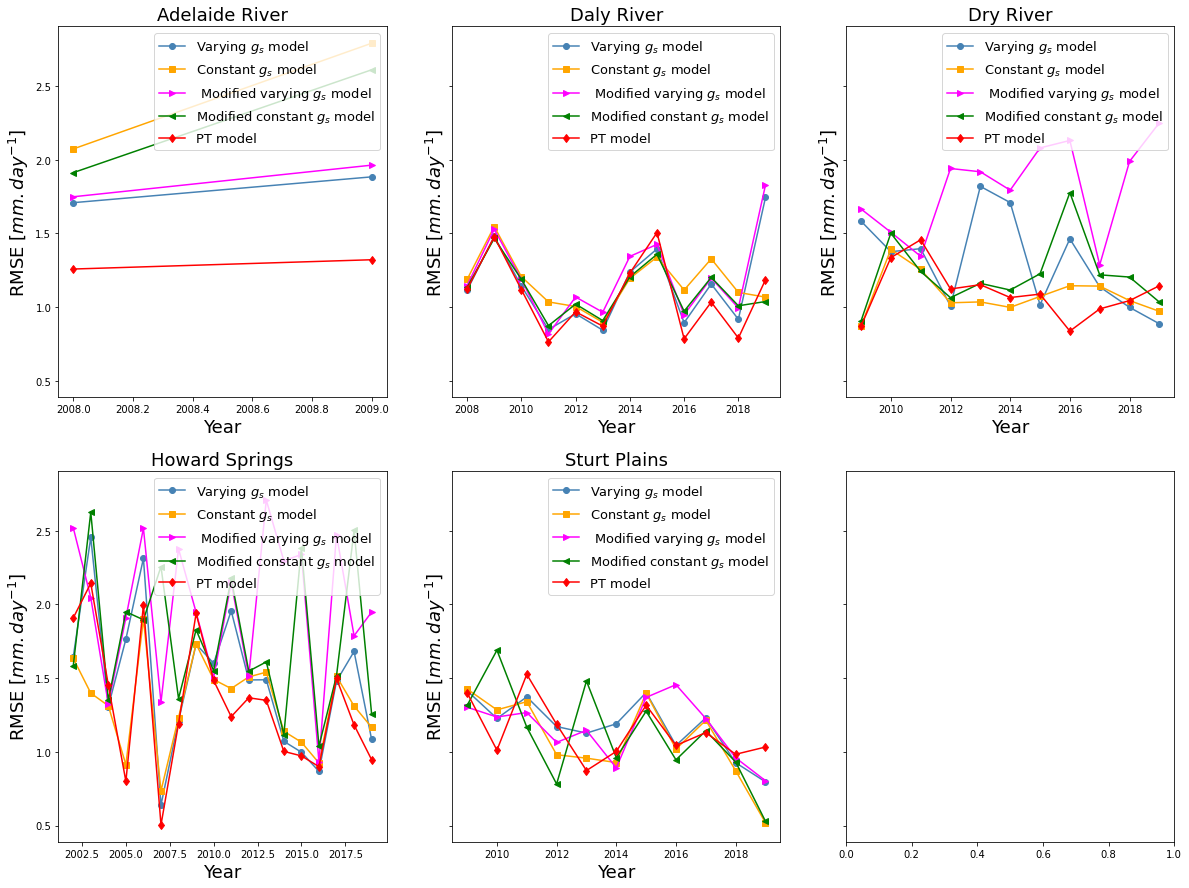

In [69]:
Sites = ["Ade","Dal","Dry","How","Stu"]
SiteTitle = ["Adelaide River","Daly River","Dry River","Howard Springs","Sturt Plains"]

Years_study = {"Ade":[2008,2009],"Dal":[2008,2019],"Dry":[2009,2019],"How":[2002,2019],"Stu":[2009,2019]}

Liste_years = []
TotYear = 0
for site in Sites:
    years = np.arange(Years_study[site][0],Years_study[site][1]+1,1)
    Liste_years.append(years)
    TotYear += years.size

ResStore = []

model_list = [PM_run_var, PM_run_cst, PM_run_2var, PM_run_2cst, PT_run, PM_run_classic]
Bounds = [[(0.1,1),(0,0.1)],[(0.1,1),(0,0.1)],[(0.1,1),(0,0.1)],[(0.1,1),(0,0.1)],[(0.010,0.13),(0,0.075)],""]

ListLabel = [r"Varying $g_s$ model", r"Constant $g_s$ model",r" Modified varying $g_s$ model",r"Modified constant $g_s$ model", "PT model"]
Marker_style = ["o","s", ">", "<", "d"]
colors = ["steelblue","orange", "magenta", "green","red"]

fig, axe = plt.subplots(2,3,figsize = (20,15), sharey = True)

for a, ax, title in zip(range(len(Sites)), axe.flatten(),SiteTitle):
    print(f"------------------- {Sites[a]} -----------------")

    # select one site (Howard Springs)
    ds = xr.open_mfdataset(eddy_files[a])
    ds_orig = ds.copy()
    # Filtering out data gaps marked as -9999
    ds = ds_orig.where(ds_orig != -9999.) 
    ds_all = ds.copy()
    
    for model, spec_bounds, model_label, model_marker, model_color in zip(model_list, Bounds, ListLabel, Marker_style, colors):
        
        YearsPlot = []
        RmsePlotVar = []
        
        for j in range(len(Liste_years[a])):
        
            # select the data
            Data = DataChose(ds,str(Liste_years[a][j]),fPAR_data_process(fPAR_files[a],dates_fPAR))
            
            if model != PM_run_classic:
                coeff_calib = calibration(Data,model,bounds = spec_bounds)
                timeSerie = model(Data, coeff_calib[0], coeff_calib[1])
            else:
                timeSerie = model(Data)
            RMSE_val = RMSE(Data.Fe.to_numpy()*60*60*24, timeSerie*60*60*24)
            
            YearsPlot.append(Liste_years[a][j])
            RmsePlotVar.append(RMSE_val)
    
        ax.plot(YearsPlot,RmsePlotVar,marker = model_marker, label = model_label, color = model_color)
        ax.set_xlabel("Year", size = 18)
        ax.set_ylabel(r"RMSE $[mm.day^{-1}]$", size = 18)
        ax.set_title(title, size = 18)
        ax.legend(loc = 1,prop={'size': 13})
plt.savefig(different_sites, dpi = 150)

## References
* Barton, 1979, *A parameterization of the evaporation from nonsaturated surfaces*. In:Journal of **AppliedMeteorologyvol. 18, no. 1, pp. 43–47.**

* Fisher, J. B., Tu, K. P., and Baldocchi, D. D., 2008 *Global estimates of the land–atmosphere water fluxbased on monthly AVHRR and ISLSCP-II data, validated at 16 FLUXNET sites* In: **Remote Sensing ofEnvironmentvol. 112, no. 3, pp. 901–919.**

* Martens, B., Miralles, D. G., Lievens, H., Van Der Schalie, R., De Jeu, R. A., Fernández-Prieto, D., Beck, H. E.,Dorigo, W. A., and Verhoest, N. E, 2017 *GLEAM v3: Satellite-based land evaporation and root-zonesoil moisture* In:**Geoscientific Model Developmentvol. 10, no. 5, pp. 1903–1925**

* Miralles, D. G., Holmes, T., De Jeu, R., Gash, J., Meesters, A., and Dolman, A, 2011 *Global land-surfaceevaporation estimated from satellite-based observations*  In:**Hydrology and Earth System Sciencesvol. 15, no. 2, pp. 453–469**